<div class="alert alert-success">
    
<h2><center>Projet 7</center></h2>
    
<center>"Implémentez un modèle de scoring"</br></center>
<center>|notebook 1|</br>
</center></div>


<div class="alert alert-info" role="alert">
 <h5>Importation des librairies:</h5>
</div>

In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import joblib
import shap
# File system manangement
import os

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.model_selection import train_test_split


from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier


## Scikit Learn library
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     HalvingGridSearchCV, cross_validate)

from sklearn.metrics import (precision_score, roc_auc_score, recall_score, 
                             f1_score, fbeta_score, confusion_matrix, roc_curve, 
                             PrecisionRecallDisplay, ConfusionMatrixDisplay,
                            precision_recall_curve)
from sklearn.feature_selection import SelectKBest, f_classif

import timeit


from sklearn.pipeline import make_pipeline
# metrics
from sklearn.metrics import accuracy_score

## imbalanced-learn
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, n_jobs=-1)


<div class="alert alert-info" role="alert">
 <h5>Quelques fonctions utiles pour notre travail:</h5>
</div>

In [149]:
# Fonctionnes utilisées dans le travail:


def description_file(df):
    """
    Méthode utilisée pour décrire un DataFrame.

    Args:
    -----------------
        df (pandas.DataFrame): Dataset à décrire
    Returns:
    -----------------
        DataFrame
    """
    file_description = pd.DataFrame(columns=['nb d\'individus',
                                             'nb de features',
                                             'proportion de remplissage',
                                             'doublons'], index=['data'])
    file_description['proportion de remplissage'] = [df.notna()
                                                     .mean().mean()*100]
    file_description['nb de features'] = [df.shape[1]]
    file_description['nb d\'individus'] = [df.shape[0]]
    file_description['doublons'] = [df.duplicated().sum()]
    file_description['col entièrement vides'] = len(
        [i for i in df.columns if df[i].isnull().all()])
    return file_description



#-----------------------------------------------------------------------------------------------------

def facteur_nul(df, seuil=50):
    #Fonction de taux de remplissage:

    taux_nul = ((df.isnull().sum() / df.shape[0])*100).sort_values(ascending=False).reset_index()
    taux_nul.columns = ['Variable','Taux_de_Null']
    taux_nul_individus = taux_nul[taux_nul.Taux_de_Null >= seuil]
    
    return taux_nul_individus

#-----------------------------------------------------------------------------------------------------

def nan_seuil_graph(df, seuil):
    
    df["Taux_de_Null"] = 100-df["Taux_de_Null"]
    df = df.sort_values("Taux_de_Null", ascending=False) 
    #Seuil de suppression des features
    global seuil_graphe
    seuil_graphe= seuil
    #figure
    fig = plt.figure(figsize=(7, 13))
    font_title = {'weight': 'bold','size': 20,}
    sns.barplot(x="Taux_de_Null", y="Variable", data=df,palette="ch:s=1.5,rot=-.90")

    #ajouter la ligne seuil
    plt.axvline(x=seuil_graphe, linewidth=2, color = 'b')
    plt.text(seuil_graphe+2, 42, 'Seuil de suppression des features', fontsize = 10, color = 'b')

    plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
    plt.xlabel("Taux de remplissage (%)", fontsize= 20)
    plt.ylabel("Features", fontsize= 20)
    
    plt.show()

#-----------------------------------------------------------------------------------------------------
    
def colonnes_a_conserver(df):
    features_a_conserver= df[df['Taux_de_Null']>=seuil_graphe].drop(columns=['Taux_de_Null'])
    features_a_conserver.reset_index(inplace=True, drop=False)
    features_a_conserver.drop(['index'], axis=1, inplace=True)
    features_a_conserver_value=features_a_conserver['Variable'].values
    
    return features_a_conserver_value

#-----------------------------------------------------------------------------------------------------

def boxplots_numDATA (df, col_num, titre):
    
    # Visualation des features numériques :
    # return : Baxplots
    """    Remarque: - le titre doit être fourni en tant que string 'titre...'
    """    

    fig = plt.figure(constrained_layout=True, figsize=[15,30])
    fig.suptitle(titre, size=30, fontweight="bold", y=1.03)
    spec = fig.add_gridspec(ncols=2, nrows=len(col_num), width_ratios=[1,1])

    # Création des boxPlots 
    col_boxplot = 0

    for i in range(len(col_num)): #nombre d'images        
        for j in range(2): #paire d'images            
            if i % 2 == 0:

                if col_boxplot > len(col_num) - 1:
                    break

                ax_box = fig.add_subplot(spec[i, j])
                boxplot = sns.boxplot(data=df, x=col_num[col_boxplot], ax=ax_box, color='green')

                boxplot.set_title(col_num[col_boxplot][0:-5].capitalize(), fontdict={ "fontsize": 15, "fontweight": "bold" })
                col_boxplot += 1


    return sns.despine(fig)  

#-----------------------------------------------------------------------------------------------------

def delete_outliers_Zscore(df):
    # Outliers avec Z-score ( on choisit un seuil standard = 3):
    '''Suppression des outliers selon la méthode Z-score'''
    
    threshold = 3
    for col in df.select_dtypes(include = ['int32','float64']).columns.tolist() :
        df[col + "_zscore"] = (df[col] - df[col].mean()) / df[col].std()
        df.loc[(df[col + "_zscore"] > threshold) | (df[col + "_zscore"] < -threshold), col] = np.nan
        del df[col + "_zscore"]
        
    return df

#-----------------------------------------------------------------------------------------------------

def barplot_and_pie(df, title, subtitle_keyword):
    """
    Method used to plot a bar and pie graph.
    Parameters:
    -----------------
        df (pandas.DataFrame): Column dataset to analyze
        title (str): Graph name
        subtitle_keyword (str); Subtitle graph name
    Returns:
    -----------------
        None.
        PLot the graphs.
    """

    # Getting the data to plot them
    data = df.sort_values(ascending=False).value_counts().values.tolist()
    labels = df.sort_values(ascending=False).value_counts().index.tolist()

    if len(data) > 10:
        figsize = [25, 10]
    else:
        figsize = [9, 5]

    # defining the color palette
    colors = sns.color_palette("Paired")

    # Setting up the fig
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    fig.suptitle(title, size=25)

    # Setting up the pieplot
    ax1.set_title(subtitle_keyword + " by percentage (%)", size=14)
    ax1.pie(x=data, labels=labels, colors=colors, autopct='%1.1f%%')

    # Setting up the barplot
    ax2.set_title(subtitle_keyword + " by quantity (#)", size=14)
    plot = sns.barplot(x=labels, y=data, ax=ax2, palette=colors)
    plot.set_xticklabels(labels=labels, rotation=70, size=12,
                         horizontalalignment="right")

    for index, d in enumerate(data):
        plt.text(x=index, y=d+1, s=f"{d}", horizontalalignment="center",
                 fontdict=dict(fontsize=10, color="gray"))

    plt.tight_layout()
    plt.show()
    
#-------------------------------------------------------------------------------------

# Custom Score
"""Nous devons pénaliser les FN qui sont des prêts qui seront en défaut et qui ont été prédits de manière incorrecte.
Pour cette raison, nous allons définir un score personnalisé."""

def custom_score(y_test, y_pred):
    """
    Method used to calculate a score based on the penalization of False Negatives.

    Parameters:
    -----------------
        y_test (series): True values
        y_pred (series): Predicted values
        threshold (float): Threshold value to use
        
    Returns:
    -----------------
        Score. (float): Score obtained based on the rules defined to measure. 
    """
    
    TN_rate = 1        # Loans that are not in default and were predicted correctly
    TP_rate = 1        # Loans that are in default and were predicted correctly
    FP_rate = -1        # Loans that are not in default and were predicted incorrectly
    FN_rate = -10      # Loans that are in default and were were predicted incorrectly
    
    # Getting all values based on confusion matrix
    (TN, FP, FN, TP) = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()

    # Total of default and not default cases
    total_not_default = TN + FP     # Not default cases
    total_default = TP + FN         # Default cases 
    
    gain_total = TN*TN_rate + TP*TP_rate + FP*FP_rate + FN*FN_rate
    gain_maximun = total_not_default*TN_rate + total_default*TP_rate
    gain_minumun = total_not_default*TN_rate + total_default*FN_rate
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain_total - gain_minumun) / (gain_maximun - gain_minumun)
    
    return score

#--------------------------------------------------------------------------------------
# create a function for trained models evaluation
def evaluate_model(model_pipeline):
    # prediction
    train_pred = model_pipeline.predict(X_train)
    test_pred = model_pipeline.predict(X_val)
    
    train_pred_proba = model_pipeline.predict_proba(X_train)
    test_pred_proba = model_pipeline.predict_proba(X_val)
    
    # evaluations
    print('Training & Validation ROC AUC Scores:\n', '-'*40)
    print('Training   roc auc score= {:.4f}'.format(roc_auc_score(y_train, train_pred_proba[:, 1])))
    print('Validation roc auc score= {:.4f}'.format(roc_auc_score(y_val, test_pred_proba[:, 1])))
    print('')
    print('Training & Validation Confusion Metrices:')
    print('Training   confusion matrix:\n', confusion_matrix(y_train, train_pred))
    print('Validation confusion matrix:\n', confusion_matrix(y_val, test_pred))
    
#-----------------------------------------------------------------------------------------------

def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 20 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:20]))), 
            df['importance_normalized'].head(20), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:20]))))
    ax.set_yticklabels(df['feature'].head(20))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df


<div class="alert alert-info" role="alert">
 <h3>Importer les données sauvgardées:</h3>

</div>

In [3]:
# List files available
print(os.listdir("Data_p6"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'desktop.ini', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'LGBM_P7.pkl', 'POS_CASH_balance.csv', 'preprocessor_P7.joblib', 'previous_application.csv', 'sample_submission.csv', 'try_API_P7.py']


In [4]:
# Training data
app_train = pd.read_csv("Data_p6/application_train.csv",
                        low_memory=False,
                        verbose=False,
                        encoding='ISO-8859-1',
                        dtype={'Special': 'object'})
print('Données d\'entraînement: ', app_train.shape)


Données d'entraînement:  (307511, 122)


##### --- Description de données train ---

In [5]:
description_file(app_train)

,nb d'individus,nb de features,proportion de remplissage,doublons,col entièrement vides
data,307511,122,75.604058,0,0


In [6]:
# Regardons le nb des données manquantes par colonne:
app_train.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [7]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [8]:
app_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
app_train['AMT_GOODS_PRICE'].dtypes

dtype('float64')

Les données d'apprentissage comportent 307,511 observations et 122 caractéristiques (variables), y compris la TARGET (l'étiquette que nous voulons prédire).

In [10]:
# Testing data
app_test = pd.read_csv("Data_p6/application_test.csv")
print('Données test: ', app_test.shape)


Données test:  (48744, 121)


L'ensemble de test est considérablement plus petit et ne contient pas la colonne TARGET

##### --- Description des données test ---

In [11]:
description_file(app_test)

,nb d'individus,nb de features,proportion de remplissage,doublons,col entièrement vides
data,48744,121,76.188313,0,0


In [12]:
app_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


In [13]:
#afficher le type de chaque colonne:
pd.set_option('display.max_columns', None)
pd.DataFrame([app_train.dtypes])

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,int64,int64,object,object,object,object,int64,float64,float64,float64,float64,object,object,object,object,object,float64,int64,int64,float64,int64,float64,int64,int64,int64,int64,int64,int64,object,float64,int64,int64,object,int64,int64,int64,int64,int64,int64,int64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,object,object,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64


In [14]:
pd.reset_option("display.max_colwidth")

In [15]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97


<div class="alert alert-info" role="alert">
 <h3>Partie exploratoire:</h3>

</div>

##### Type des colonnes:

In [16]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

##### Variables catégorielles

In [17]:
# Number of unique classes in each object column

In [18]:
# create a dataframe with object dtype columns
unique_df = pd.DataFrame(app_train.select_dtypes('object').nunique()).reset_index()
unique_df.columns = ['Column','No. of Unique Values']

# extract the unique classes in each column
unique_df['Unique Values'] = unique_df['Column'].apply(lambda x: app_train[x].unique())
unique_df.sort_values(by='No. of Unique Values')

,Column,No. of Unique Values,Unique Values
0,NAME_CONTRACT_TYPE,2,"[Cash loans, Revolving loans]"
2,FLAG_OWN_CAR,2,"[N, Y]"
3,FLAG_OWN_REALTY,2,"[Y, N]"
15,EMERGENCYSTATE_MODE,2,"[No, nan, Yes]"
1,CODE_GENDER,3,"[M, F, XNA]"
13,HOUSETYPE_MODE,3,"[block of flats, nan, terraced house, specific..."
12,FONDKAPREMONT_MODE,4,"[reg oper account, nan, org spec account, reg ..."
6,NAME_EDUCATION_TYPE,5,"[Secondary / secondary special, Higher educati..."
7,NAME_FAMILY_STATUS,6,"[Single / not married, Married, Civil marriage..."
8,NAME_HOUSING_TYPE,6,"[House / apartment, Rented apartment, With par..."


La plupart des variables catégorielles ont un nombre d'entrées uniques relativement faible .

Regardons le genre:

In [19]:
app_train[app_train['CODE_GENDER']=='XNA']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
35657,141289,0,Revolving loans,XNA,Y,Y,0,207000.0,382500.0,19125.0,337500.0,Unaccompanied,Working,Secondary / secondary special,Married,Municipal apartment,0.020713,-20232,-10044,-10024.0,-3537,13.0,1,1,1,1,1,0,NaN,2.0,3,3,TUESDAY,10,0,0,0,0,0,0,Business Entity Type 1,NaN,0.295998,0.461482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-286.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
38566,144669,0,Revolving loans,XNA,N,Y,2,157500.0,270000.0,13500.0,225000.0,Family,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13717,-2797,-2241.0,-4659,NaN,1,1,1,1,1,0,Low-skill Laborers,4.0,2,2,FRIDAY,16,0,0,0,0,0,0,Industry: type 3,NaN,0.709205,0.310818,0.0165,0.0368,0.9811,NaN,NaN,0.0,0.0690,0.0417,NaN,0.0233,NaN,0.0115,NaN,0.0000,0.0168,0.0382,0.9811,NaN,NaN,0.0,0.0690,0.0417,NaN,0.0238,NaN,0.0120,NaN,0.0000,0.0167,0.0368,0.9811,NaN,NaN,0.0,0.0690,0.0417,NaN,0.0237,NaN,0.0117,NaN,0.000,NaN,block of flats,0.0090,"Stone, brick",No,0.0,0.0,0.0,0.0,-493.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,3.0,0.0,4.0
83382,196708,0,Revolving loans,XNA,N,Y,1,135000.0,405000.0,20250.0,225000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.035792,-10647,-1228,-183.0,-1671,NaN,1,1,1,1,1,0,Core staff,3.0,2,2,THURSDAY,15,0,0,0,0,0,0,Kindergarten,0.404970,0.659185,0.076984,0.0773,0.1353,0.9921,0.8912,NaN,0.0,0.1379,0.1667,0.0417,NaN,0.0630,0.0621,0.0000,NaN,0.0788,0.1404,0.9921,0.8955,NaN,0.0,0.1379,0.1667,0.0417,NaN,0.0689,0.0647,0.0000,NaN,0.0781,0.1353,0.9921,0.8927,NaN,0.0,0.1379,0.1667,0.0417,NaN,0.0641,0.0632,0.0000,NaN,reg oper spec account,block of flats,0.076

supprimons le genre identifié comme 'XNA' dans la colonne CODE_GENDER:

In [20]:
# extract all records doesn't have XNA value in CODE_GENDER column
app_train = app_train[app_train['CODE_GENDER']!='XNA']

# check
app_train['CODE_GENDER'].value_counts()

F    202448
M    105059
Name: CODE_GENDER, dtype: int64

Changeons le

In [21]:
app_train['DAYS_LAST_PHONE_CHANGE'].unique()

array([-1134.,  -828.,  -815., ..., -3988., -3899., -3538.])

In [22]:
app_train['TARGET'].value_counts()


0    282682
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:ylabel='Frequency'>

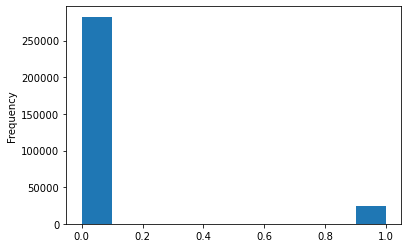

In [23]:
app_train['TARGET'].astype(int).plot.hist()

La target est ce qu'on nous demande de prévoir :
        
        - 0 pour le prêt a été remboursé à temps,
        - 1 indiquant que le client a eu des difficultés de paiement.


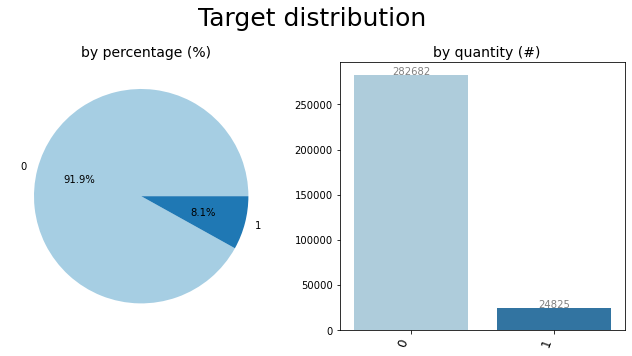

In [147]:
barplot_and_pie(app_train["TARGET"], "Target distribution", " ")



Ici, nous pouvons voir à quel point l'ensemble de données est déséquilibré, nous sommes donc confrontés à un problème de classification déséquilibré
Il est facile d'identifier qu'il y a des prêts qui ont été remboursés (0) en comparaison des prêts qui n'ont pas été remboursés (1)s
Nous allons traiter la classe déséquilibrée dans un pipeline lors de la modélisation


<div class="alert alert-info" role="alert">
 <h3>Taux de remplissage:</h3>

</div>

In [25]:
# Pour afficher tous les taux de remplissage, on utilise la fonction facteur_nul avec un seuil de 0
taux_de_remplissage = facteur_nul(app_train, 0)
taux_de_remplissage.head(20)

,Variable,Taux_de_Null
0,COMMONAREA_MEDI,69.872231
1,COMMONAREA_AVG,69.872231
2,COMMONAREA_MODE,69.872231
3,NONLIVINGAPARTMENTS_MODE,69.433216
4,NONLIVINGAPARTMENTS_AVG,69.433216
5,NONLIVINGAPARTMENTS_MEDI,69.433216
6,FONDKAPREMONT_MODE,68.386411
7,LIVINGAPARTMENTS_MODE,68.355192
8,LIVINGAPARTMENTS_AVG,68.355192
9,LIVINGAPARTMENTS_MEDI,68.355192


In [26]:
taux_de_remplissage.tail(50)

,Variable,Taux_de_Null
72,FLAG_DOCUMENT_2,0.0
73,FLAG_DOCUMENT_3,0.0
74,FLAG_DOCUMENT_4,0.0
75,FLAG_DOCUMENT_5,0.0
76,FLAG_DOCUMENT_6,0.0
77,FLAG_DOCUMENT_7,0.0
78,FLAG_DOCUMENT_9,0.0
79,FLAG_DOCUMENT_21,0.0
80,FLAG_DOCUMENT_10,0.0
81,FLAG_DOCUMENT_11,0.0


In [27]:
taux_de_remplissage.shape

(122, 2)

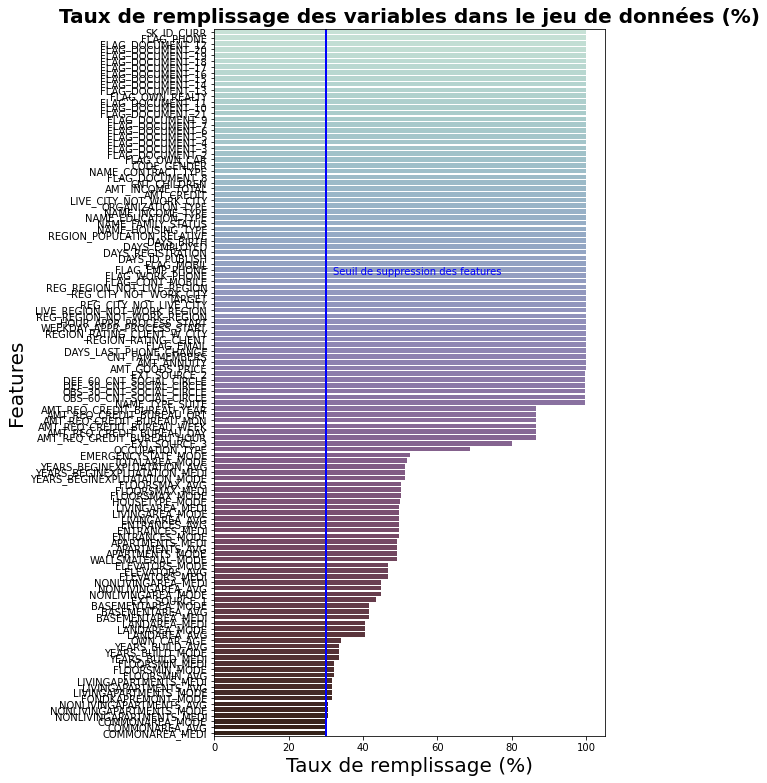

In [28]:
#Remarque: avant d'utiliser nan_seuil_graph il faut lancer la fonction facteur_nul.

nan_seuil_graph(taux_de_remplissage, 30)

In [29]:
colonnes_a_conserver(taux_de_remplissage)

array(['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAPARTMENTS_MEDI', 'FLOORSMIN_AVG', 'FLOORSMIN_MODE',
       'FLOORSMIN_MEDI', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
       'YEARS_BUILD_AVG', 'OWN_CAR_AGE', 'LANDAREA_MEDI', 'LANDAREA_MODE',
       'LANDAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG',
       'BASEMENTAREA_MODE', 'EXT_SOURCE_1', 'NONLIVINGAREA_MODE',
       'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'ELEVATORS_MEDI',
       'ELEVATORS_AVG', 'ELEVATORS_MODE', 'WALLSMATERIAL_MODE',
       'APARTMENTS_MEDI', 'APARTMENTS_AVG', 'APARTMENTS_MODE',
       'ENTRANCES_MEDI', 'ENTRANCES_AVG', 'ENTRANCES_MODE',
       'LIVINGAREA_AVG', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI',
       'HOUSETYPE_MODE', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI',
       'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATI

In [30]:
data2=app_train[colonnes_a_conserver(taux_de_remplissage)]

In [31]:
data2.isna().count()

COMMONAREA_MEDI             307507
COMMONAREA_AVG              307507
COMMONAREA_MODE             307507
NONLIVINGAPARTMENTS_MODE    307507
NONLIVINGAPARTMENTS_AVG     307507
                             ...  
NAME_HOUSING_TYPE           307507
NAME_FAMILY_STATUS          307507
NAME_EDUCATION_TYPE         307507
NAME_INCOME_TYPE            307507
SK_ID_CURR                  307507
Length: 122, dtype: int64

In [32]:
description_file(data2)

,nb d'individus,nb de features,proportion de remplissage,doublons,col entièrement vides
data,307507,122,75.603949,0,0


In [33]:
# Supprimer toutes les colonnes avec 20 % ou plus de valeurs manquantes
data2 = data2.dropna(thresh=0.8*len(data2), axis=1)


In [34]:
data2.columns

Index(['EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_TYPE_SUITE',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2',
       'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS',
       'DAYS_LAST_PHONE_CHANGE', 'CNT_CHILDREN', 'FLAG_DOCUMENT_8',
       'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_OWN_REALTY', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOC

In [35]:
description_file(data2)

,nb d'individus,nb de features,proportion de remplissage,doublons,col entièrement vides
data,307507,72,98.570909,0,0


-------------------


### Répartir les données en:

   - Données numériques
   - Données catégoriques
       

##### --- Données numériques ---

In [36]:
#données numériques:
colonnes_numériques=data2.select_dtypes(['int64','float64']).columns.to_list()
colonnes_numériques

['EXT_SOURCE_3',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'EXT_SOURCE_2',
 'AMT_GOODS_PRICE',
 'AMT_ANNUITY',
 'CNT_FAM_MEMBERS',
 'DAYS_LAST_PHONE_CHANGE',
 'CNT_CHILDREN',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_12',
 'AMT_CREDIT',
 'AMT_INCOME_TOTAL',
 'FLAG_PHONE',
 'LIVE_CITY_NOT_WORK_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'TARGET',
 'REG_CITY_NOT_LIVE_CITY',
 'LIVE_REGI

##### --- Données catégoriques ---

In [37]:
#données catégoriques:
colonnes_catégoriques = data2.drop(colonnes_numériques, axis=1).columns.to_list()
colonnes_catégoriques

['NAME_TYPE_SUITE',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'NAME_HOUSING_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_EDUCATION_TYPE',
 'NAME_INCOME_TYPE']

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:title={'center':'Distribution du nombre de NaN par ligne'}, ylabel='Density'>

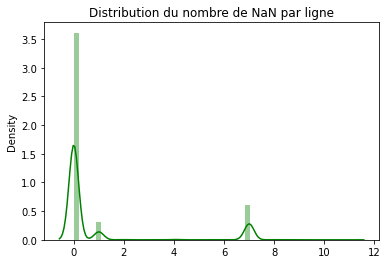

In [38]:
plt.title('Distribution du nombre de NaN par ligne')
sns.distplot(data2.isna().sum(axis=1), color="green")

Conclusion : 
       
       - Plusieurs lignes contiennent des Nan.

##### --- Matrice de corrélation (Pearson correlation) ---

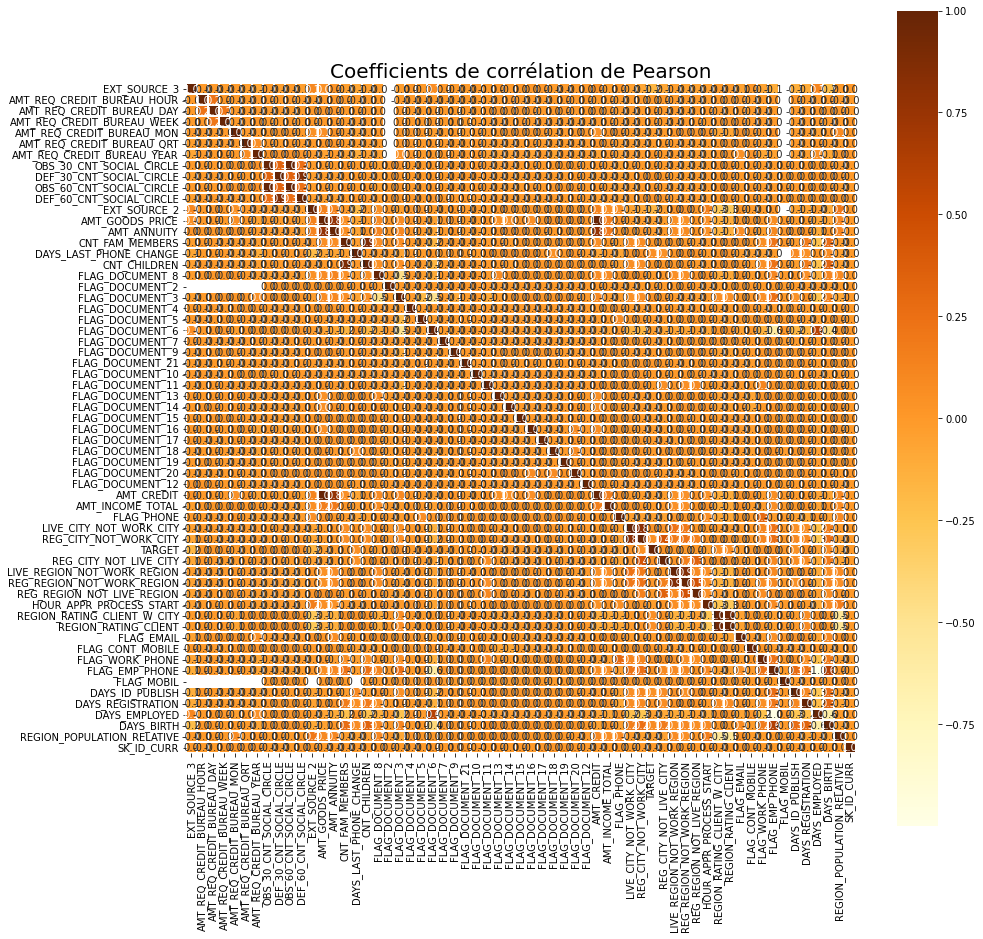

In [39]:
matrice_de_correlation = data2[colonnes_numériques].corr()
#heatmap
fig = plt.figure(figsize=(15,15))
sns.heatmap(matrice_de_correlation, square=True, linewidths=0.01, annot=True,fmt=".1f", cmap='YlOrBr')
plt.title("Coefficients de corrélation de Pearson", fontsize=20)
plt.show()

In [40]:
# Top 5 Columns with Positive Correlation with our TARGET 
print('Top 5 Columns with Positive Correlation with TARGET\n', '-'*50)
print(app_train.corr()['TARGET'].sort_values().tail(5))

# Negative ones
print('\nTop 5 Columns with Negative Correlation with TARGET\n', '-'*50)
print(app_train.corr()['TARGET'].sort_values().head(5))

Top 5 Columns with Positive Correlation with TARGET
 --------------------------------------------------
DAYS_LAST_PHONE_CHANGE         0.055219
REGION_RATING_CLIENT           0.058901
REGION_RATING_CLIENT_W_CITY    0.060895
DAYS_BIRTH                     0.078242
TARGET                         1.000000
Name: TARGET, dtype: float64

Top 5 Columns with Negative Correlation with TARGET
 --------------------------------------------------
EXT_SOURCE_3    -0.178926
EXT_SOURCE_2    -0.160471
EXT_SOURCE_1    -0.155317
DAYS_EMPLOYED   -0.044934
FLOORSMAX_AVG   -0.044009
Name: TARGET, dtype: float64


Pas de corrélation entre notre cible et les autres features.

In [41]:

## create Credit/Income and Annuity/Income percentages
app_train['Credit/Income'] = app_train['AMT_CREDIT']/app_train['AMT_INCOME_TOTAL']
app_train['Annuity/Income'] = app_train['AMT_ANNUITY']/app_train['AMT_INCOME_TOTAL']

## show only clients with difficuties
app_train[app_train['TARGET']==1].sort_values(by='Credit/Income', ascending=True)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Credit/Income,Annuity/Income
12840,114967,1,Cash loans,F,N,Y,1,117000000.0,562491.0,26194.5,454500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010643,-12615,-922,-6762.0,-3643,NaN,1,1,0,1,0,0,Laborers,3.0,2,2,TUESDAY,14,0,0,0,0,0,0,Business Entity Type 3,0.460809,0.113161,0.145543,0.1031,0.0947,0.9791,NaN,NaN,0.00,0.2069,0.1667,NaN,0.0688,NaN,0.0615,NaN,NaN,0.1050,0.0983,0.9791,NaN,NaN,0.0000,0.2069,0.1667,NaN,0.0704,NaN,0.0641,NaN,NaN,0.1041,0.0947,0.9791,NaN,NaN,0.00,0.2069,0.1667,NaN,0.0700,NaN,0.0626,NaN,NaN,NaN,block of flats,0.0715,"Stone, brick",No,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.004808,0.000224
197551,329042,1,Cash loans,F,Y,Y,0,405000.0,76410.0,9067.5,67500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0.010556,-15023,-572,-972.0,-313,6.0,1,1,1,1,1,0,NaN,2.0,3,3,WEDNESDAY,12,1,1,0,1,1,0,Other,0.779197,0.452913,0.119878,0.1577,0.2042,0.9960,NaN,NaN,0.00,0.2414,0.2083,NaN,0.0461,NaN,0.1419,NaN,0.0332,0.1607,0.2119,0.9960,NaN,NaN,0.0000,0.2414,0.2083,NaN,0.0471,NaN,0.1479,NaN,0.0352,0.1593,0.2042,0.9960,NaN,NaN,0.00,0.2414,0.2083,NaN,0.0469,NaN,0.1445,NaN,0.0339,NaN,block of flats,0.1189,"Stone, brick",No,3.0,2.0,3.0,1.0,-1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.0,3.0,0.188667,0.022389
106358,223392,1,Cash loans,M,Y,Y,1,540000.0,106974.0,8451.0,94500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.006629,-13399,-1049,-1654.0,-2333,9.0,1,1,1,1,1,0,Laborers,3.0,2,2,FRIDAY,10,0,0,0,0,0,0,Transport: type 4,NaN,0.000868,NaN,NaN,NaN,0.9851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0101,NaN,NaN,NaN,NaN,0.9851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0105,NaN,NaN,NaN,NaN,0.9851,NaN,NaN,N

In [42]:
## show only clients with difficuties
app_train[app_train['TARGET']==1].sort_values(by='Credit/Income', ascending=True)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Credit/Income,Annuity/Income
12840,114967,1,Cash loans,F,N,Y,1,117000000.0,562491.0,26194.5,454500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010643,-12615,-922,-6762.0,-3643,NaN,1,1,0,1,0,0,Laborers,3.0,2,2,TUESDAY,14,0,0,0,0,0,0,Business Entity Type 3,0.460809,0.113161,0.145543,0.1031,0.0947,0.9791,NaN,NaN,0.00,0.2069,0.1667,NaN,0.0688,NaN,0.0615,NaN,NaN,0.1050,0.0983,0.9791,NaN,NaN,0.0000,0.2069,0.1667,NaN,0.0704,NaN,0.0641,NaN,NaN,0.1041,0.0947,0.9791,NaN,NaN,0.00,0.2069,0.1667,NaN,0.0700,NaN,0.0626,NaN,NaN,NaN,block of flats,0.0715,"Stone, brick",No,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.004808,0.000224
197551,329042,1,Cash loans,F,Y,Y,0,405000.0,76410.0,9067.5,67500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0.010556,-15023,-572,-972.0,-313,6.0,1,1,1,1,1,0,NaN,2.0,3,3,WEDNESDAY,12,1,1,0,1,1,0,Other,0.779197,0.452913,0.119878,0.1577,0.2042,0.9960,NaN,NaN,0.00,0.2414,0.2083,NaN,0.0461,NaN,0.1419,NaN,0.0332,0.1607,0.2119,0.9960,NaN,NaN,0.0000,0.2414,0.2083,NaN,0.0471,NaN,0.1479,NaN,0.0352,0.1593,0.2042,0.9960,NaN,NaN,0.00,0.2414,0.2083,NaN,0.0469,NaN,0.1445,NaN,0.0339,NaN,block of flats,0.1189,"Stone, brick",No,3.0,2.0,3.0,1.0,-1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.0,3.0,0.188667,0.022389
106358,223392,1,Cash loans,M,Y,Y,1,540000.0,106974.0,8451.0,94500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.006629,-13399,-1049,-1654.0,-2333,9.0,1,1,1,1,1,0,Laborers,3.0,2,2,FRIDAY,10,0,0,0,0,0,0,Transport: type 4,NaN,0.000868,NaN,NaN,NaN,0.9851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0101,NaN,NaN,NaN,NaN,0.9851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0105,NaN,NaN,NaN,NaN,0.9851,NaN,NaN,N

1er record avec Crédit/Revenu < 0,005 et revenu supérieur à 117 millions n'est pas logique. Ça doit être faux.

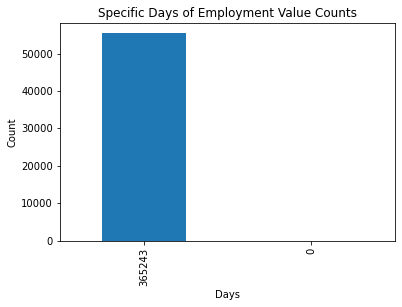

In [43]:
# visualiser les jours d'emploi des clients >=0
app_train[app_train['DAYS_EMPLOYED']>=0]['DAYS_EMPLOYED'].value_counts().plot(kind='bar');
plt.title('Specific Days of Employment Value Counts')
plt.xlabel('Days')
plt.ylabel('Count')
plt.show()

In [44]:
# the percentage of this value in our dataset
value_perctage = len(app_train[app_train['DAYS_EMPLOYED']==365243])/len(app_train) * 100
print('Records with this value represent {:.2f}% of all data.'.format(value_perctage))

Records with this value represent 18.01% of all data.


18 % de notre ensemble de données avec cette valeur, il peut s'agir d'une erreur et elle doit être remplacée par la valeur moyenne ou médiane.

Effet de l'âge sur le remboursement:

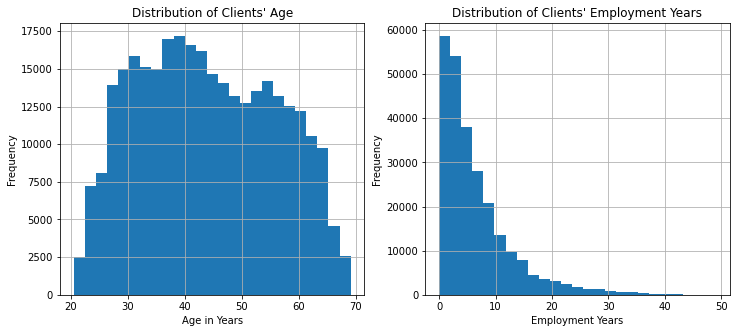

In [45]:
# go deeper with the distributions

## convert birth and employment days into years
app_train['YEARS_BIRTH'] = app_train['DAYS_BIRTH']/-365.25
app_train['YEARS_EMPLOYED'] = app_train['DAYS_EMPLOYED']/-365.25

plt.figure(figsize=(12,5))
## age histogram for clients with DAYS_LAST_PHONE_CHANGE = 0
plt.subplot(1, 2, 1)
app_train['YEARS_BIRTH'].hist(bins=25)
plt.title('Distribution of Clients\' Age')
plt.xlabel('Age in Years')
plt.ylabel('Frequency')

## employment histogram for clients with DAYS_LAST_PHONE_CHANGE = 0 without the wrong value '365243'
plt.subplot(1, 2, 2)
app_train[app_train['YEARS_EMPLOYED']!=(365243/-365.25)]['YEARS_EMPLOYED'].hist(bins=25)
plt.title('Distribution of Clients\' Employment Years')
plt.xlabel('Employment Years')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Distribution of Ages')

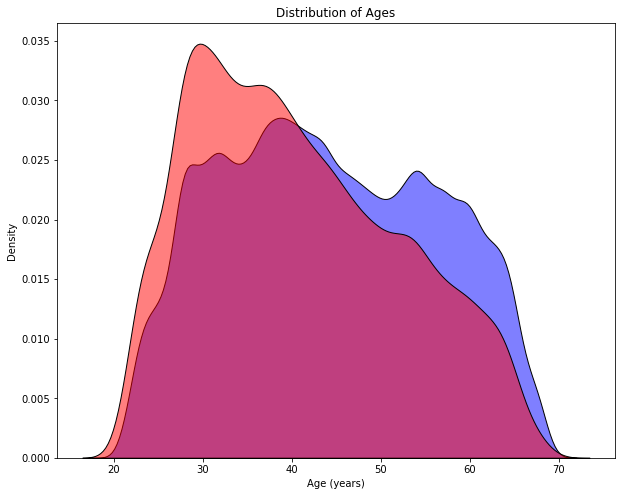

In [46]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'YEARS_BIRTH'] , label = 'target == 0',color='b', multiple="stack",alpha=.5)

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'YEARS_BIRTH'] , label = 'target == 1',color='r', multiple="stack",alpha=.5)

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')



Target == 1 s'incline vers l'extrémité la plus jeune de la plage. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la target. Regardons cette relation sous un autre angle : incapacité moyenne à rembourser les crédits par tranche d'âge.

Pour faire ce graphique, nous avons d'abord découpé la catégorie d'âge en tranches de 5 ans chacune. Ensuite, pour chaque tranche, nous calculons la valeur moyenne de la target, qui nous indique le ratio de prêts non remboursés dans chaque catégorie d'âge.

In [47]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,-9461,25.920548,"(25.0, 30.0]"
1,0,-16765,45.931507,"(45.0, 50.0]"
2,0,-19046,52.180822,"(50.0, 55.0]"
3,0,-19005,52.068493,"(50.0, 55.0]"
4,0,-19932,54.608219,"(50.0, 55.0]"
5,0,-16941,46.413699,"(45.0, 50.0]"
6,0,-13778,37.747945,"(35.0, 40.0]"
7,0,-18850,51.643836,"(50.0, 55.0]"
8,0,-20099,55.065753,"(55.0, 60.0]"
9,0,-14469,39.641096,"(35.0, 40.0]"


In [48]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,-8532.795625,23.377522
"(25.0, 30.0]",0.111442,-10155.219690,27.822520
"(30.0, 35.0]",0.102814,-11854.848377,32.479037
"(35.0, 40.0]",0.089416,-13707.908041,37.555912
"(40.0, 45.0]",0.078491,-15497.661233,42.459346
"(45.0, 50.0]",0.074171,-17323.900441,47.462741
"(50.0, 55.0]",0.066968,-19196.494791,52.593136
"(55.0, 60.0]",0.055316,-20984.285455,57.491193
"(60.0, 65.0]",0.052737,-22780.547460,62.412459


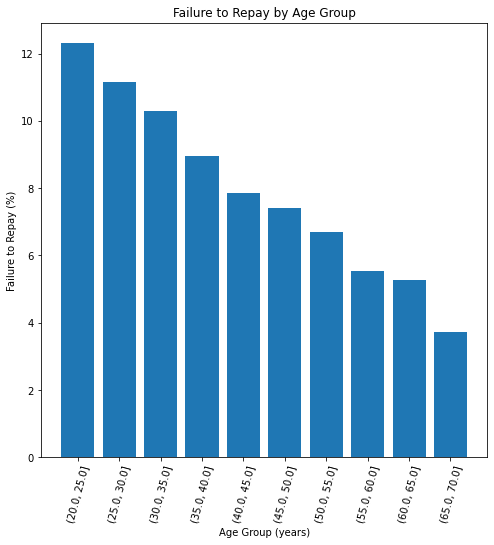

In [49]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

Il y a une tendance claire : les jeunes demandeurs sont plus susceptibles de ne pas rembourser le prêt ! Le taux d'impayés est supérieur à 10 % pour les trois tranches d'âge les plus jeunes et inférieur à 5 % pour la tranche d'âge la plus élevée.

Il s'agit d'informations qui pourraient être directement utilisées par la banque : étant donné que les clients plus jeunes sont moins susceptibles de rembourser le prêt, il faudrait peut-être leur fournir davantage de conseils de planification financière. Cela ne signifie pas que la banque devrait discriminer les jeunes clients, mais il serait judicieux de prendre des mesures de précaution pour aider les jeunes clients à payer à temps.

Existe-t-il une relation entre le sexe et la capacité de remboursement ?

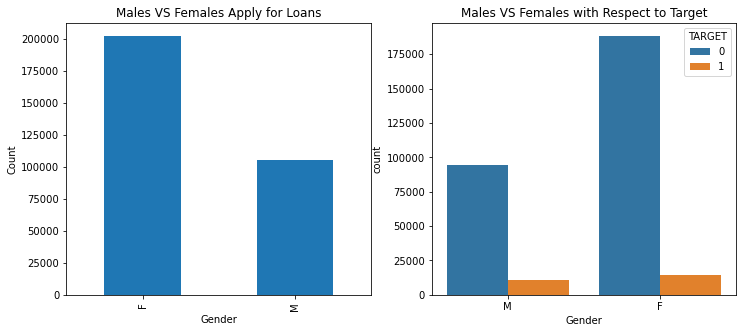

In [50]:

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
app_train[app_train['CODE_GENDER']!='XNA']['CODE_GENDER'].value_counts().plot(kind='bar', title='Males VS Females Apply for Loans');
plt.xlabel('Gender')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(data=app_train[app_train['CODE_GENDER']!='XNA'], x='CODE_GENDER', hue='TARGET');
plt.title('Males VS Females with Respect to Target')
plt.xlabel('Gender')
plt.show()

Les femmes demandent plus de prêts que les hommes. Le sexe n'est pas affecté dans notre target

Pour quel type de contrat de prêt les clients postulent-ils le plus ?

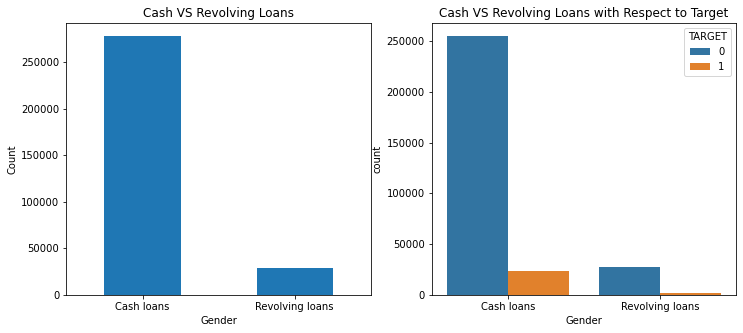

In [51]:
# Whih type of loan contract clients applys more for?

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
app_train['NAME_CONTRACT_TYPE'].value_counts().plot(kind='bar', title='Cash VS Revolving Loans');
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
sns.countplot(data=app_train, x='NAME_CONTRACT_TYPE', hue='TARGET')
plt.title('Cash VS Revolving Loans with Respect to Target')
plt.xlabel('Gender')
plt.show()

La plupart des clients ont tendance à contracter des prêts en espèces plutôt que des prêts renouvelables.
la target n'a pas été affecté. 

Le nombre d'enfants du client affecte-t-il la capacité de remboursement ?

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).


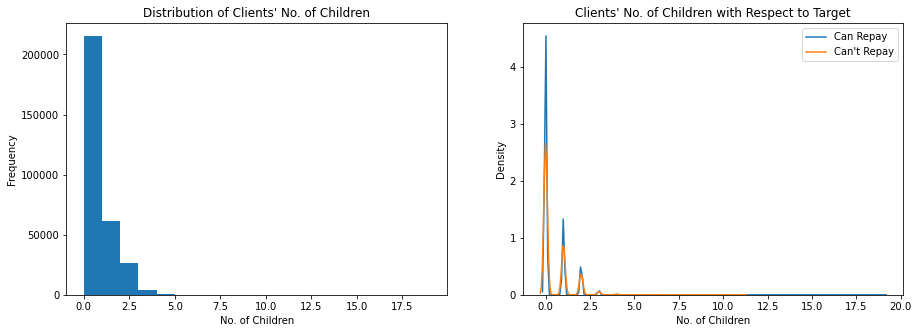

In [52]:

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
app_train['CNT_CHILDREN'].plot(kind='hist', bins=19, title='Distribution of Clients\' No. of Children');
plt.xlabel('No. of Children')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.distplot(app_train[app_train['TARGET']==0]['CNT_CHILDREN'], hist=False, label='Can Repay');
sns.distplot(app_train[app_train['TARGET']==1]['CNT_CHILDREN'], hist=False, label='Can\'t Repay');
plt.title('Clients\' No. of Children with Respect to Target')
plt.xlabel('No. of Children')
plt.legend()
plt.show()

Les clients sans enfants demandent plus de prêts que les autres, et avec l'augmentation du nombre d'enfants, les clients n'ont pas tendance à prêter.

Existe-t-il une relation entre le revenu du client et le montant du prêt demandé ?
Le revenu et le crédit affectent-ils la capacité de remboursement ?


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).


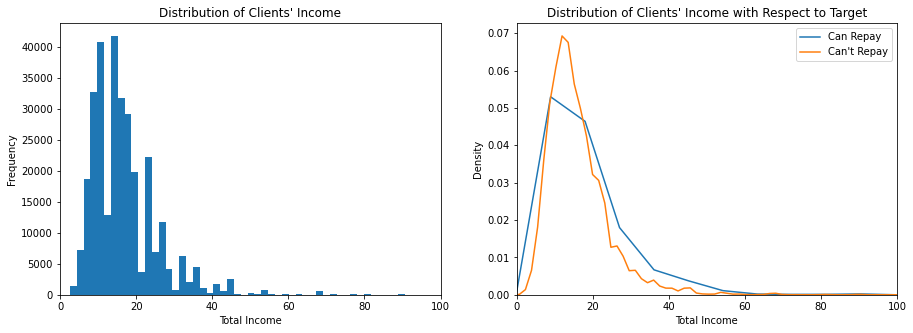

In [53]:

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
proper_income_df = app_train[app_train['AMT_INCOME_TOTAL']!=117000000.0]
proper_income_df['AMT_INCOME_TOTAL'] = proper_income_df['AMT_INCOME_TOTAL']/10000
proper_income_df['AMT_INCOME_TOTAL'].plot(kind='hist', bins=1000, title='Distribution of Clients\' Income');
plt.xlabel('Total Income')
plt.xlim([0,100])

plt.subplot(1, 2, 2)
sns.distplot(proper_income_df[proper_income_df['TARGET']==0]['AMT_INCOME_TOTAL'], hist=False, bins=1000, label='Can Repay');
sns.distplot(proper_income_df[proper_income_df['TARGET']==1]['AMT_INCOME_TOTAL'], hist=False, bins=1000, label='Can\'t Repay');
plt.title('Distribution of Clients\' Income with Respect to Target')
plt.xlabel('Total Income')
plt.xlim([0,100])
plt.legend();
plt.show()

normalisons pour voir l'intrigue correctement


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 576x576 with 0 Axes>

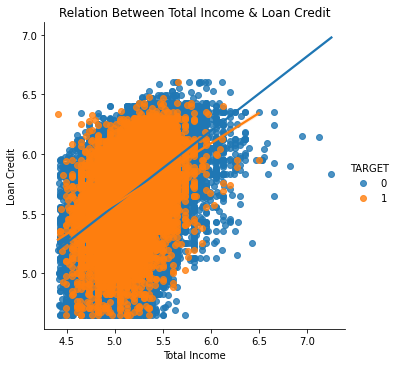

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).


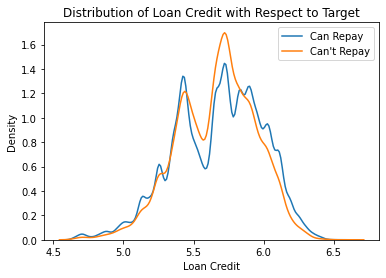

In [54]:
proper_income_df['log_AMT_INCOME_TOTAL'] = np.log10(proper_income_df['AMT_INCOME_TOTAL']*10000)
proper_income_df['log_AMT_CREDIT'] = np.log10(proper_income_df['AMT_CREDIT'])

plt.figure(figsize=(8,8))
sns.lmplot(x='log_AMT_INCOME_TOTAL', y='log_AMT_CREDIT', data=proper_income_df, hue='TARGET');
plt.title('Relation Between Total Income & Loan Credit')
plt.xlabel('Total Income')
plt.ylabel('Loan Credit')
plt.show()

sns.distplot(proper_income_df[proper_income_df['TARGET']==0]['log_AMT_CREDIT'], hist=False, label='Can Repay');
sns.distplot(proper_income_df[proper_income_df['TARGET']==1]['log_AMT_CREDIT'], hist=False, label='Can\'t Repay');
plt.title('Distribution of Loan Credit with Respect to Target');
plt.xlabel('Loan Credit')
plt.legend();

Les clients à faible revenu ont tendance à demander des prêts plus que les autres à revenu élevé.
Plus le revenu du client est élevé, plus le montant du prêt demandé est élevé.
Les clients dont le revenu est supérieur à 3 millions ont toujours tendance à rembourser, donc cette fonctionn
alité peut aider notre target.


quel est le type de revenu le plus élevé des clients ?

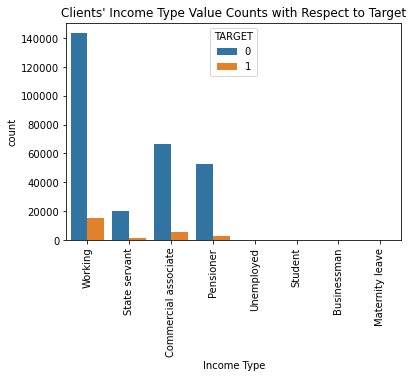

NAME_INCOME_TYPE      TARGET
Businessman           0             10
Commercial associate  0          66256
                      1           5360
Maternity leave       0              3
                      1              2
Pensioner             0          52380
                      1           2982
State servant         0          20454
                      1           1249
Student               0             18
Unemployed            0             14
                      1              8
Working               0         143547
                      1          15224
Name: TARGET, dtype: int64

In [55]:

ax = sns.countplot(data=app_train, x='NAME_INCOME_TYPE', hue='TARGET');
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90);
plt.title('Clients\' Income Type Value Counts with Respect to Target')
plt.xlabel('Income Type')
plt.show()

print('\n'*2)
app_train.groupby('NAME_INCOME_TYPE')['TARGET'].value_counts()

Les clients qui travaillent sont plus disposés à demander des prêts que les autres. Bien que quelques hommes d'affaires et étudiants demandent des prêts, ils remboursent toujours.

Quel est le diplôme d'enseignement supérieur le plus élevé pour les clients ?

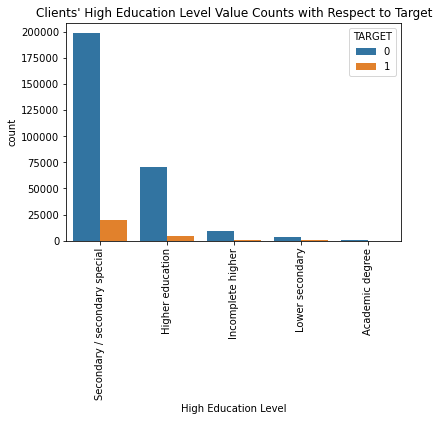

NAME_EDUCATION_TYPE            TARGET
Academic degree                0            161
                               1              3
Higher education               0          70853
                               1           4009
Incomplete higher              0           9404
                               1            872
Lower secondary                0           3399
                               1            417
Secondary / secondary special  0         198865
                               1          19524
Name: TARGET, dtype: int64

In [56]:

ax = sns.countplot(data=app_train, x='NAME_EDUCATION_TYPE', hue='TARGET');
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90);
plt.title('Clients\' High Education Level Value Counts with Respect to Target')
plt.xlabel('High Education Level')
plt.show()

print('\n'*2)
app_train.groupby('NAME_EDUCATION_TYPE')['TARGET'].value_counts()

Les clients ayant un niveau d'études secondaires sont plus disposés à demander des prêts que les autres.
Près de 98% des clients ayant un niveau d'études supérieures peuvent rembourser leurs prêts.

Y a t-il une relation entre la possession d'une voiture ou d'un bien immobilier et la demande de prêt ou la capacité de remboursement ?

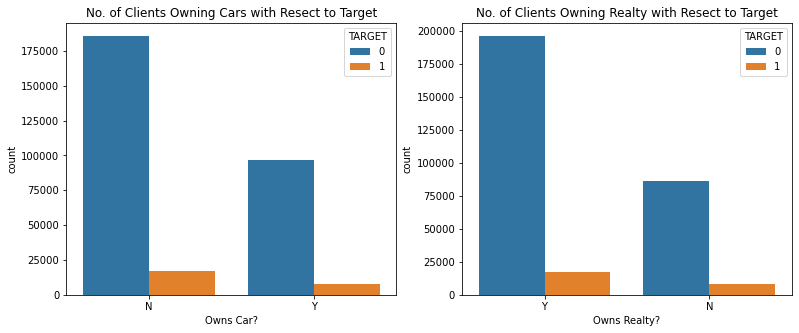

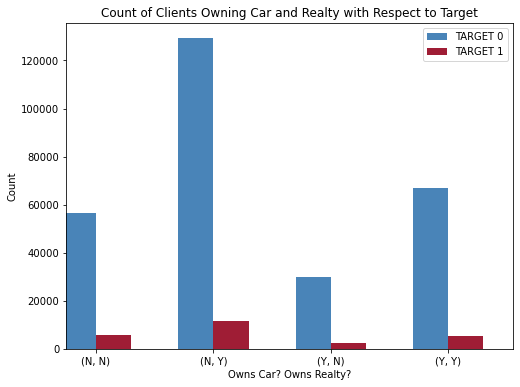

In [57]:

plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)
sns.countplot(data=app_train, x='FLAG_OWN_CAR', hue='TARGET')
plt.title('No. of Clients Owning Cars with Resect to Target')
plt.xlabel('Owns Car?')

plt.subplot(1, 2, 2)
sns.countplot(data=app_train, x='FLAG_OWN_REALTY', hue='TARGET')
plt.title('No. of Clients Owning Realty with Resect to Target')
plt.xlabel('Owns Realty?')
plt.show()


plt.figure(figsize=(8,6))
app_train[app_train['TARGET']==0].groupby(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']).count()['TARGET'].plot(kind='bar', color='#4984B8', width=0.3,  position=1, label='TARGET 0')
app_train[app_train['TARGET']==1].groupby(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']).count()['TARGET'].plot(kind='bar', color='#9F1D35', width=0.3,  position=0, label='TARGET 1')
plt.title('Count of Clients Owning Car and Realty with Respect to Target');
plt.ylabel('Count')
plt.xlabel('Owns Car? Owns Realty?')
plt.xticks(rotation=0)
plt.legend()


Les clients qui ne possèdent pas de voiture mais qui possèdent des biens immobiliers ont tendance à demander des prêts plus que les autres, et vice versa.
La plupart des deux peuvent bien rembourser, mais celui qui possède les deux peut rembourser plus que celui qui ne les possède pas.

EXISTE-T-IL une relation entre l'année d'emploi et la capacité de remboursement?


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).


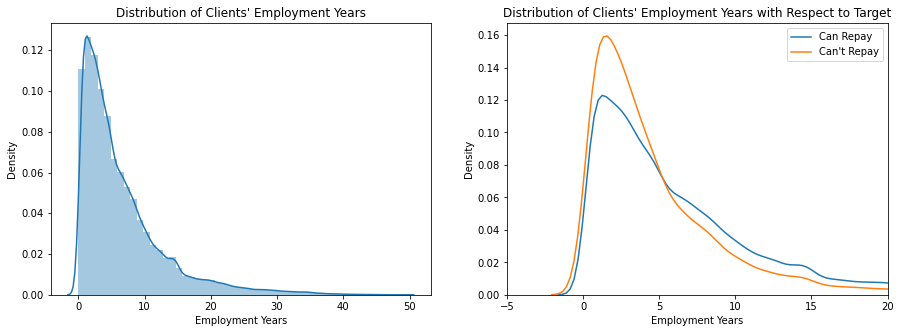

In [58]:

proper_days_empolyed_df = app_train[app_train['DAYS_EMPLOYED']!=365243]
proper_days_empolyed_df['YEARS_EMPLOYED'] = proper_days_empolyed_df['DAYS_EMPLOYED']/-365.25

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.distplot(proper_days_empolyed_df['YEARS_EMPLOYED'])
plt.title('Distribution of Clients\' Employment Years')
plt.xlabel('Employment Years')

plt.subplot(1, 2, 2)
sns.distplot(proper_days_empolyed_df[proper_days_empolyed_df['TARGET']==0]['YEARS_EMPLOYED'], hist=False, label='Can Repay');
sns.distplot(proper_days_empolyed_df[proper_days_empolyed_df['TARGET']==1]['YEARS_EMPLOYED'], hist=False, label='Can\'t Repay');
plt.title('Distribution of Clients\' Employment Years with Respect to Target');
plt.xlim([-5,20])
plt.xlabel('Employment Years')
plt.legend();

Les clients avec des années d'emploi de moins de 5 ans ont tendance à demander des prêts plus que les autres, et ils sont moins susceptibles de rembourser, en particulier moins de 2 ans, et vice versa.


<div class="alert alert-info" role="alert">
 <h3>Traitement des OUTLIERS:</h3>

</div>

---------------------------------------------
#### Traitement des OUTLIERS:

- On travaille sur les données numériques
- On utilise les BoxPlots pour l'affichage
----------------------------------------------
- On traite les Outliers par la méthode de: 
    - Percentile ou Z-score

les colonnes qui ont des valeurs continues sont toutes les colonnes à l'exception de 'target' et 'flags'

In [59]:
col_num_continues = [col for col in colonnes_numériques if col!="TARGET" and col[:5]!='FLAG_']
col_num_continues

['EXT_SOURCE_3',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'EXT_SOURCE_2',
 'AMT_GOODS_PRICE',
 'AMT_ANNUITY',
 'CNT_FAM_MEMBERS',
 'DAYS_LAST_PHONE_CHANGE',
 'CNT_CHILDREN',
 'AMT_CREDIT',
 'AMT_INCOME_TOTAL',
 'LIVE_CITY_NOT_WORK_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'REG_CITY_NOT_LIVE_CITY',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_REGION_NOT_LIVE_REGION',
 'HOUR_APPR_PROCESS_START',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'REGION_POPULATION_RELATIVE',
 'SK_ID_CURR']

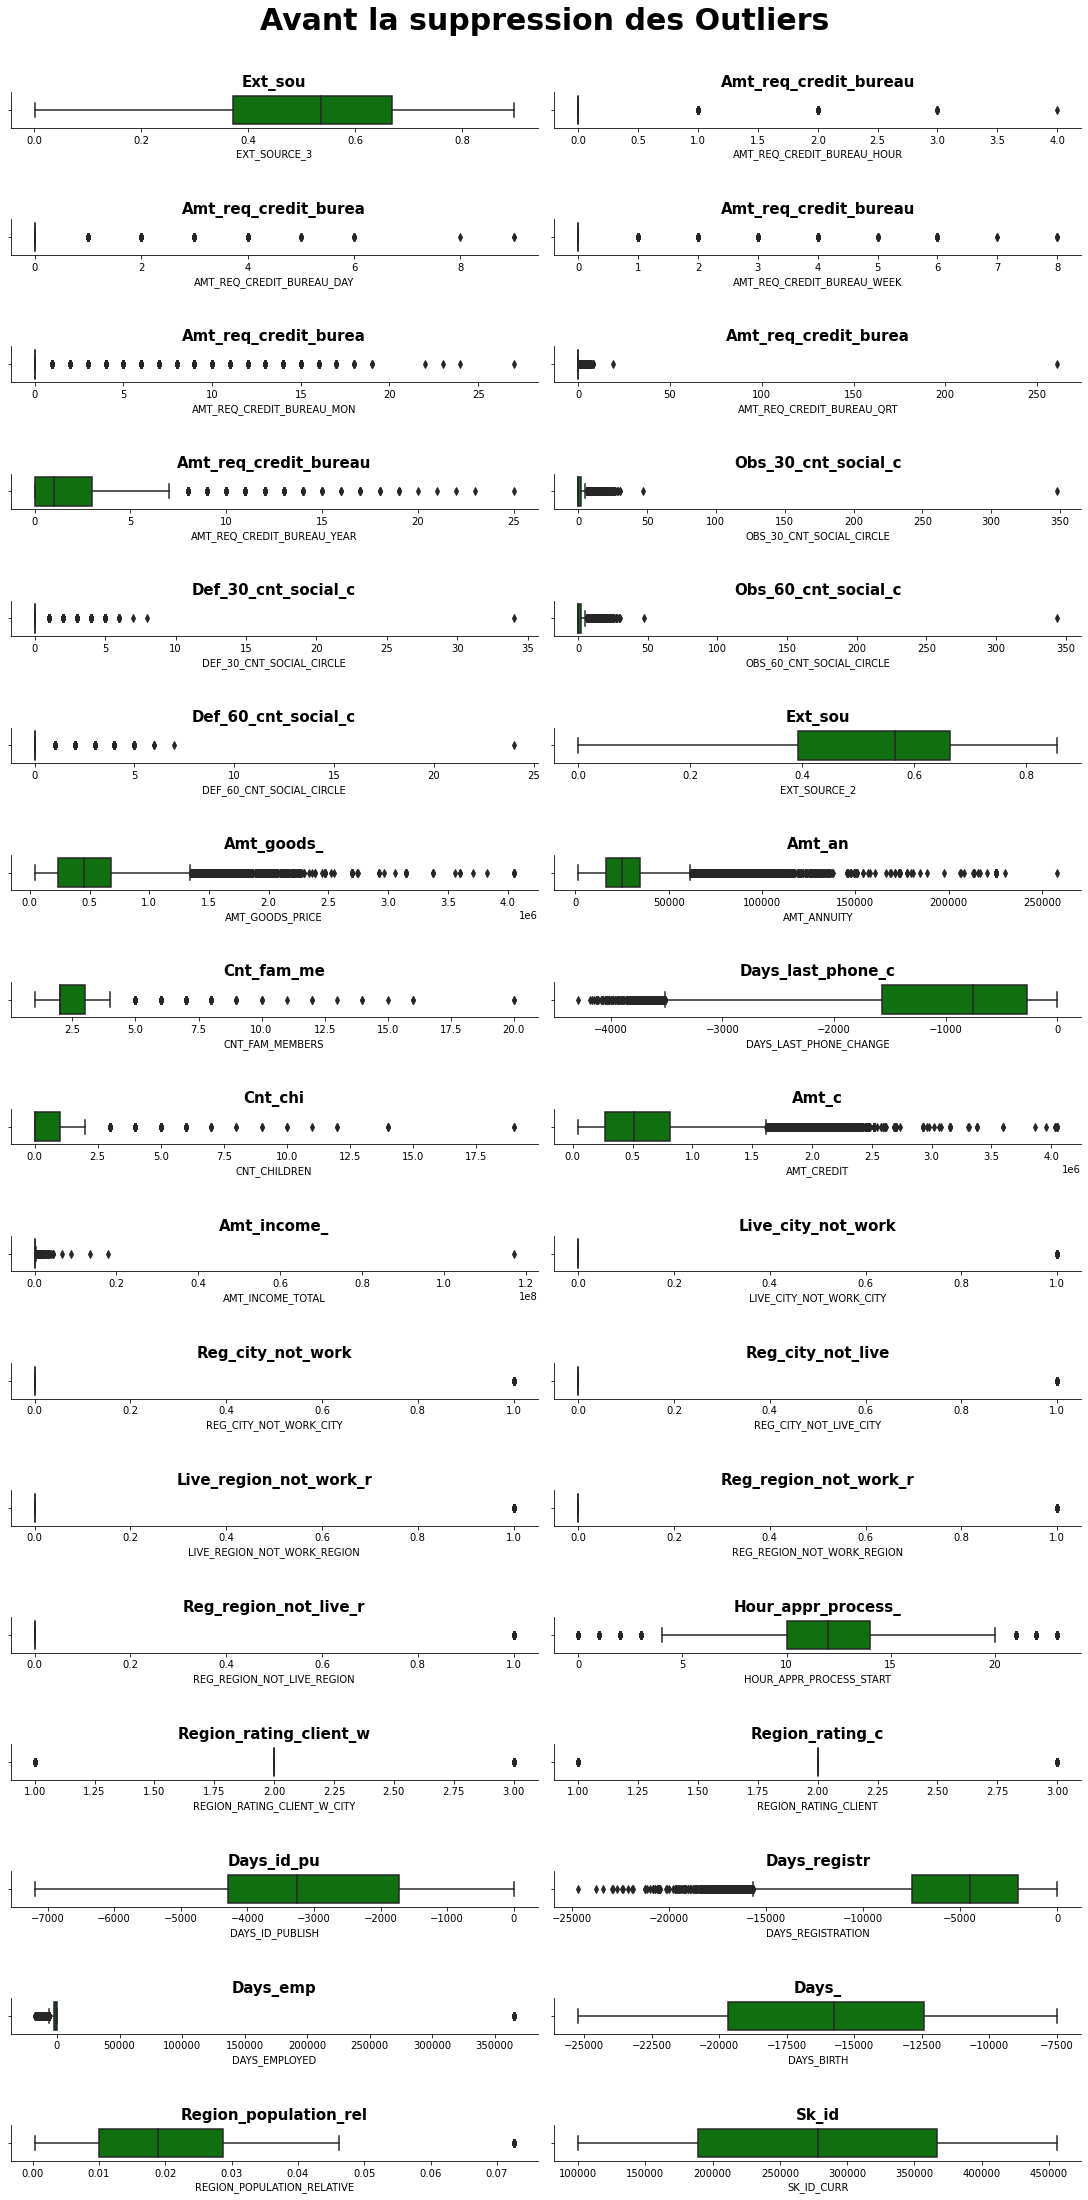

In [60]:
# Afficher la distribution des features numériques:
boxplots_numDATA (data2, col_num_continues, 'Avant la suppression des Outliers')

In [61]:
data3= data2.copy()
data3

,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_9,FLAG_DOCUMENT_21,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_OWN_REALTY,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_12,AMT_CREDIT,AMT_INCOME_TOTAL,FLAG_PHONE,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,TARGET,REG_CITY_NOT_LIVE_CITY,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,REG_REGION_NOT_LIVE_REGION,HOUR_APPR_PROCESS_START,WEEKDAY_APPR_PROCESS_START,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,FLAG_EMAIL,FLAG_CONT_MOBILE,ORGANIZATION_TYPE,FLAG_WORK_PHONE,FLAG_EMP_PHONE,FLAG_MOBIL,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_BIRTH,REGION_POPULATION_RELATIVE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE,SK_ID_CURR
0,0.139376,0.0,0.0,0.0,0.0,0.0,1.0,Unaccompanied,2.0,2.0,2.0,2.0,0.262949,351000.0,24700.5,1.0,-1134.0,0,0,Cash loans,M,N,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,406597.5,202500.0,1,0,0,1,0,0,0,0,10,WEDNESDAY,2,2,0,1,Business Entity Type 3,0,1,1,-2120,-3648.0,-637,-9461,0.018801,House / apartment,Single / not married,Secondary / secondary special,Working,100002
1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Family,1.0,0.0,1.0,0.0,0.622246,1129500.0,35698.5,2.0,-828.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0,0,0,0,1293502.5,270000.0,1,0,0,0,0,0,0,0,11,MONDAY,1,1,0,1,School,0,1,1,-291,-1186.0,-1188,-16765,0.003541,House / apartment,Married,Higher education,State servant,100003
2,0.729567,0.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,0.0,0.0,0.0,0.0,0.555912,135000.0,6750.0,1.0,-815.0,0,0,Revolving loans,M,Y,0,0,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,135000.0,67500.0,1,0,0,0,0,0,0,0,9,MONDAY,2,2,0,1,Government,1,1,1,-2531,-4260.0,-225,-19046,0.010032,House / apartment,Single / not married,Secondary / secondary special,Working,100004
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,2.0,0.0,2.0,0.0,0.650442,297000.0,29686.5,2.0,-617.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,312682.5,135000.0,0,0,0,0,0,0,0,0,17,WEDNESDAY,2,2,0,1,Business Entity Type 3,0,1,1,-2437,-9833.0,-3039,-19005,0.008019,House / apartment,Civil marriage,Secondary / secondary special,Working,100006
4,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,0.0,0.0,0.0,0.0,0.322738,513000.0,21865.5,1.0,-1106.0,0,1,Cash loans,M,N,0,0,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,513000.0,121500.0,0,1,1,0,0,0,0,0,11,THURSDAY,2,2,0,1,Religion,0,1,1,-3458,-4311.0,-3038,-19932,0.028663,House / apartment,Single / not married,Secondary / secondary special,Working,100007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,0.0,0.0,0.0,0.0,0.681632,225000.0,27558.0,1.0,-273.0,0,1,Cash loans,M,N,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0,0,0,0,254700.0,157500.0,0,0,0,0,0,0,0,0,15,THURSDAY,1,1,0,1,Services,0,1,1,-1982,-8456.0,-236,-9327,0.032561,With parents,Separated,Secondary / secondary special,Working,456251
307507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,0.0,0.0,0.0,0.0,0.115992,225000.0,12001.5,1.0,0.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,269550.0,72000.0,1,0,0,0,0,0,0,0,8,MONDAY,2,2,0,1,XNA,0,0,1,-4090,-4388.0,365243,-20775,0.025164,House / apartment,Widow,Secondary / secondary special,Pensio

In [62]:
# Outliers, on peut définir un pourcentage de 0.05% par exemple:
# Pour transformer les outliers en Nan puis faire imputation des valeurs manquantes a posteriori (si besoin)...

data3 = delete_outliers_Zscore(data3)

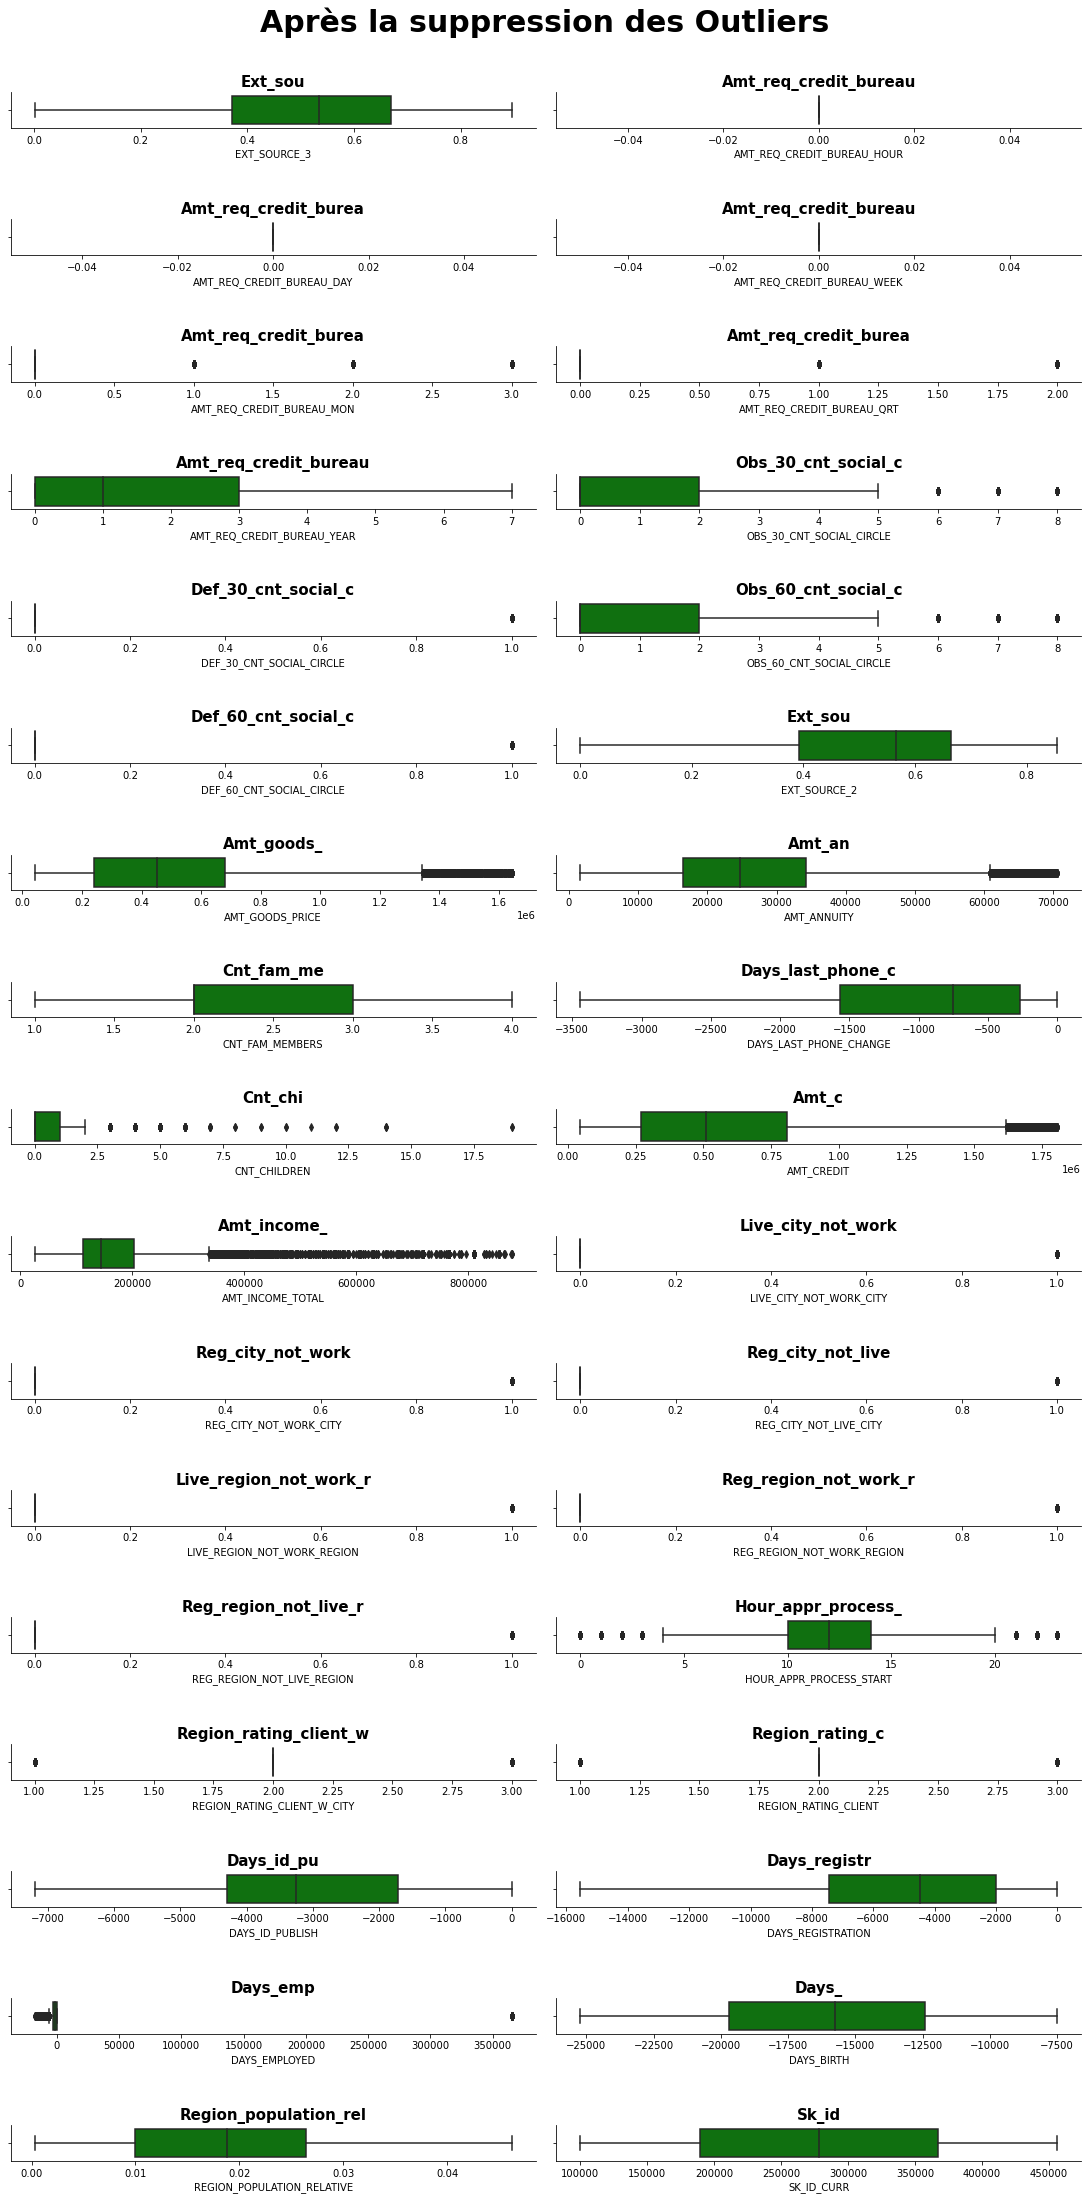

In [63]:
# Afficher la distribution des features numériques (après l'application de Percentile):
boxplots_numDATA (data3, col_num_continues, 'Après la suppression des Outliers')

In [64]:
data3

,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_9,FLAG_DOCUMENT_21,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_OWN_REALTY,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_12,AMT_CREDIT,AMT_INCOME_TOTAL,FLAG_PHONE,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,TARGET,REG_CITY_NOT_LIVE_CITY,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,REG_REGION_NOT_LIVE_REGION,HOUR_APPR_PROCESS_START,WEEKDAY_APPR_PROCESS_START,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,FLAG_EMAIL,FLAG_CONT_MOBILE,ORGANIZATION_TYPE,FLAG_WORK_PHONE,FLAG_EMP_PHONE,FLAG_MOBIL,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_BIRTH,REGION_POPULATION_RELATIVE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE,SK_ID_CURR
0,0.139376,0.0,0.0,0.0,0.0,0.0,1.0,Unaccompanied,2.0,NaN,2.0,NaN,0.262949,351000.0,24700.5,1.0,-1134.0,0,0,Cash loans,M,N,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,406597.5,202500.0,1,0,0,1,0,0,0,0,10,WEDNESDAY,2,2,0,1,Business Entity Type 3,0,1,1,-2120,-3648.0,-637,-9461,0.018801,House / apartment,Single / not married,Secondary / secondary special,Working,100002
1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Family,1.0,0.0,1.0,0.0,0.622246,1129500.0,35698.5,2.0,-828.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0,0,0,0,1293502.5,270000.0,1,0,0,0,0,0,0,0,11,MONDAY,1,1,0,1,School,0,1,1,-291,-1186.0,-1188,-16765,0.003541,House / apartment,Married,Higher education,State servant,100003
2,0.729567,0.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,0.0,0.0,0.0,0.0,0.555912,135000.0,6750.0,1.0,-815.0,0,0,Revolving loans,M,Y,0,0,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,135000.0,67500.0,1,0,0,0,0,0,0,0,9,MONDAY,2,2,0,1,Government,1,1,1,-2531,-4260.0,-225,-19046,0.010032,House / apartment,Single / not married,Secondary / secondary special,Working,100004
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,2.0,0.0,2.0,0.0,0.650442,297000.0,29686.5,2.0,-617.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,312682.5,135000.0,0,0,0,0,0,0,0,0,17,WEDNESDAY,2,2,0,1,Business Entity Type 3,0,1,1,-2437,-9833.0,-3039,-19005,0.008019,House / apartment,Civil marriage,Secondary / secondary special,Working,100006
4,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,0.0,0.0,0.0,0.0,0.322738,513000.0,21865.5,1.0,-1106.0,0,1,Cash loans,M,N,0,0,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,513000.0,121500.0,0,1,1,0,0,0,0,0,11,THURSDAY,2,2,0,1,Religion,0,1,1,-3458,-4311.0,-3038,-19932,0.028663,House / apartment,Single / not married,Secondary / secondary special,Working,100007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,0.0,0.0,0.0,0.0,0.681632,225000.0,27558.0,1.0,-273.0,0,1,Cash loans,M,N,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0,0,0,0,254700.0,157500.0,0,0,0,0,0,0,0,0,15,THURSDAY,1,1,0,1,Services,0,1,1,-1982,-8456.0,-236,-9327,0.032561,With parents,Separated,Secondary / secondary special,Working,456251
307507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,0.0,0.0,0.0,0.0,0.115992,225000.0,12001.5,1.0,0.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,269550.0,72000.0,1,0,0,0,0,0,0,0,8,MONDAY,2,2,0,1,XNA,0,0,1,-4090,-4388.0,365243,-20775,0.025164,House / apartment,Widow,Secondary / secondary special,Pensio

##### Sauvegarder les données dans un fichier .CSV: 

In [65]:
data3.to_csv('Données_P7_train.csv',encoding="UTF-8")

In [66]:
data3

,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_9,FLAG_DOCUMENT_21,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_OWN_REALTY,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_12,AMT_CREDIT,AMT_INCOME_TOTAL,FLAG_PHONE,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,TARGET,REG_CITY_NOT_LIVE_CITY,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,REG_REGION_NOT_LIVE_REGION,HOUR_APPR_PROCESS_START,WEEKDAY_APPR_PROCESS_START,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,FLAG_EMAIL,FLAG_CONT_MOBILE,ORGANIZATION_TYPE,FLAG_WORK_PHONE,FLAG_EMP_PHONE,FLAG_MOBIL,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_BIRTH,REGION_POPULATION_RELATIVE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE,SK_ID_CURR
0,0.139376,0.0,0.0,0.0,0.0,0.0,1.0,Unaccompanied,2.0,NaN,2.0,NaN,0.262949,351000.0,24700.5,1.0,-1134.0,0,0,Cash loans,M,N,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,406597.5,202500.0,1,0,0,1,0,0,0,0,10,WEDNESDAY,2,2,0,1,Business Entity Type 3,0,1,1,-2120,-3648.0,-637,-9461,0.018801,House / apartment,Single / not married,Secondary / secondary special,Working,100002
1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Family,1.0,0.0,1.0,0.0,0.622246,1129500.0,35698.5,2.0,-828.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0,0,0,0,1293502.5,270000.0,1,0,0,0,0,0,0,0,11,MONDAY,1,1,0,1,School,0,1,1,-291,-1186.0,-1188,-16765,0.003541,House / apartment,Married,Higher education,State servant,100003
2,0.729567,0.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,0.0,0.0,0.0,0.0,0.555912,135000.0,6750.0,1.0,-815.0,0,0,Revolving loans,M,Y,0,0,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,135000.0,67500.0,1,0,0,0,0,0,0,0,9,MONDAY,2,2,0,1,Government,1,1,1,-2531,-4260.0,-225,-19046,0.010032,House / apartment,Single / not married,Secondary / secondary special,Working,100004
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,2.0,0.0,2.0,0.0,0.650442,297000.0,29686.5,2.0,-617.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,312682.5,135000.0,0,0,0,0,0,0,0,0,17,WEDNESDAY,2,2,0,1,Business Entity Type 3,0,1,1,-2437,-9833.0,-3039,-19005,0.008019,House / apartment,Civil marriage,Secondary / secondary special,Working,100006
4,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,0.0,0.0,0.0,0.0,0.322738,513000.0,21865.5,1.0,-1106.0,0,1,Cash loans,M,N,0,0,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,513000.0,121500.0,0,1,1,0,0,0,0,0,11,THURSDAY,2,2,0,1,Religion,0,1,1,-3458,-4311.0,-3038,-19932,0.028663,House / apartment,Single / not married,Secondary / secondary special,Working,100007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,0.0,0.0,0.0,0.0,0.681632,225000.0,27558.0,1.0,-273.0,0,1,Cash loans,M,N,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0,0,0,0,254700.0,157500.0,0,0,0,0,0,0,0,0,15,THURSDAY,1,1,0,1,Services,0,1,1,-1982,-8456.0,-236,-9327,0.032561,With parents,Separated,Secondary / secondary special,Working,456251
307507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,0.0,0.0,0.0,0.0,0.115992,225000.0,12001.5,1.0,0.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,269550.0,72000.0,1,0,0,0,0,0,0,0,8,MONDAY,2,2,0,1,XNA,0,0,1,-4090,-4388.0,365243,-20775,0.025164,House / apartment,Widow,Secondary / secondary special,Pensio


<div class="alert alert-info" role="alert">
 <h3>Pipeline::</h3>

</div>

Pipeline:

Créer un pipeline qui impute les NaN par rapport aux colonnes (numériques et catégoriques), puis effectuer un encodage et une normalisation.

    - Données catégorielles:
- Encodage avec OrdinalEncoder.
- Imputation avec la valeur la plus fréquente.


    - Données numériques:
- Imputation avec la valeur median.
- Standariser les données avec MinMaxScaler.

In [69]:
# create a pipeline to deal with numerical features
## 1- impute with median as most of features cotain outliers
## 2- apply Min-Max Scaler get rid of the outliers
numeric_transformer = Pipeline(
    steps=[("num_imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)

In [70]:
# create a pipeline to deal with catagorical features
## 1- impute with the most frequent class "mode" 
## 2- apply One-Hot Encoding
'''categorical_transformer = Pipeline(
    steps=[("cat_imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OneHotEncoder(handle_unknown='ignore', drop='first'))]
)'''

categorical_transformer = Pipeline(
    steps=[("cat_imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OrdinalEncoder())]
)


In [71]:
# create a column transformer instant
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, make_column_selector(dtype_exclude="object")),
        ("cat", categorical_transformer, make_column_selector(dtype_include="object")),
    ]
)

In [72]:
data3['TARGET']

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307507, dtype: int64

Data Splitting

In [73]:
# separate target out of features "predictors"
X = data3.drop(["TARGET", "SK_ID_CURR"], axis=1)
y = data3['TARGET']

In [74]:
X

,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_9,FLAG_DOCUMENT_21,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_OWN_REALTY,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_12,AMT_CREDIT,AMT_INCOME_TOTAL,FLAG_PHONE,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,REG_REGION_NOT_LIVE_REGION,HOUR_APPR_PROCESS_START,WEEKDAY_APPR_PROCESS_START,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,FLAG_EMAIL,FLAG_CONT_MOBILE,ORGANIZATION_TYPE,FLAG_WORK_PHONE,FLAG_EMP_PHONE,FLAG_MOBIL,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_BIRTH,REGION_POPULATION_RELATIVE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE
0,0.139376,0.0,0.0,0.0,0.0,0.0,1.0,Unaccompanied,2.0,NaN,2.0,NaN,0.262949,351000.0,24700.5,1.0,-1134.0,0,0,Cash loans,M,N,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,406597.5,202500.0,1,0,0,0,0,0,0,10,WEDNESDAY,2,2,0,1,Business Entity Type 3,0,1,1,-2120,-3648.0,-637,-9461,0.018801,House / apartment,Single / not married,Secondary / secondary special,Working
1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Family,1.0,0.0,1.0,0.0,0.622246,1129500.0,35698.5,2.0,-828.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0,0,0,0,1293502.5,270000.0,1,0,0,0,0,0,0,11,MONDAY,1,1,0,1,School,0,1,1,-291,-1186.0,-1188,-16765,0.003541,House / apartment,Married,Higher education,State servant
2,0.729567,0.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,0.0,0.0,0.0,0.0,0.555912,135000.0,6750.0,1.0,-815.0,0,0,Revolving loans,M,Y,0,0,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,135000.0,67500.0,1,0,0,0,0,0,0,9,MONDAY,2,2,0,1,Government,1,1,1,-2531,-4260.0,-225,-19046,0.010032,House / apartment,Single / not married,Secondary / secondary special,Working
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,2.0,0.0,2.0,0.0,0.650442,297000.0,29686.5,2.0,-617.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,312682.5,135000.0,0,0,0,0,0,0,0,17,WEDNESDAY,2,2,0,1,Business Entity Type 3,0,1,1,-2437,-9833.0,-3039,-19005,0.008019,House / apartment,Civil marriage,Secondary / secondary special,Working
4,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Unaccompanied,0.0,0.0,0.0,0.0,0.322738,513000.0,21865.5,1.0,-1106.0,0,1,Cash loans,M,N,0,0,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,513000.0,121500.0,0,1,1,0,0,0,0,11,THURSDAY,2,2,0,1,Religion,0,1,1,-3458,-4311.0,-3038,-19932,0.028663,House / apartment,Single / not married,Secondary / secondary special,Working
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,0.0,0.0,0.0,0.0,0.681632,225000.0,27558.0,1.0,-273.0,0,1,Cash loans,M,N,0,0,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0,0,0,0,254700.0,157500.0,0,0,0,0,0,0,0,15,THURSDAY,1,1,0,1,Services,0,1,1,-1982,-8456.0,-236,-9327,0.032561,With parents,Separated,Secondary / secondary special,Working
307507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,0.0,0.0,0.0,0.0,0.115992,225000.0,12001.5,1.0,0.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,269550.0,72000.0,1,0,0,0,0,0,0,8,MONDAY,2,2,0,1,XNA,0,0,1,-4090,-4388.0,365243,-20775,0.025164,House / apartment,Widow,Secondary / secondary special,Pensioner
307508,0.218859,NaN,0.0,0.0,1.0,0.0,1.0,Unaccompanied,6.0,0.0,6.0,0.0,0.535722

In [75]:
# data splitting
# données d'entraînement et données de validation

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

In [76]:
X_train

,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_9,FLAG_DOCUMENT_21,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_OWN_REALTY,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_12,AMT_CREDIT,AMT_INCOME_TOTAL,FLAG_PHONE,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,REG_REGION_NOT_LIVE_REGION,HOUR_APPR_PROCESS_START,WEEKDAY_APPR_PROCESS_START,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,FLAG_EMAIL,FLAG_CONT_MOBILE,ORGANIZATION_TYPE,FLAG_WORK_PHONE,FLAG_EMP_PHONE,FLAG_MOBIL,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_BIRTH,REGION_POPULATION_RELATIVE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE
195170,NaN,0.0,0.0,0.0,0.0,1.0,2.0,Unaccompanied,0.0,0.0,0.0,0.0,0.530649,247500.0,21415.5,2.0,-771.0,0,0,Cash loans,M,Y,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,267102.0,76500.0,1,1,1,0,0,0,0,8,MONDAY,2,2,1,1,Kindergarten,1,1,1,-3708,-595.0,-674,-11202,0.015221,House / apartment,Married,Secondary / secondary special,Working
50834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,1.0,0.0,1.0,0.0,0.461411,NaN,57564.0,1.0,-853.0,0,0,Cash loans,M,N,0,0,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,NaN,180999.0,0,1,1,0,0,0,0,14,WEDNESDAY,3,3,0,1,Business Entity Type 3,0,1,1,-4163,-5446.0,-659,-20630,0.018209,House / apartment,Widow,Secondary / secondary special,Commercial associate
223598,0.680139,0.0,0.0,0.0,0.0,0.0,3.0,Unaccompanied,1.0,0.0,1.0,0.0,0.670653,679500.0,19867.5,2.0,-488.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0,0,0,0,679500.0,54000.0,0,0,0,0,0,0,0,9,MONDAY,2,2,0,1,XNA,0,0,1,-3854,-13011.0,365243,-22733,0.007120,House / apartment,Married,Secondary / secondary special,Pensioner
307014,0.595456,0.0,0.0,0.0,0.0,0.0,6.0,Family,0.0,0.0,0.0,0.0,0.743870,1125000.0,37800.0,2.0,-2452.0,0,1,Cash loans,M,Y,0,0,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,1288350.0,225000.0,1,0,0,0,0,0,0,12,TUESDAY,1,1,1,1,Business Entity Type 3,0,1,1,-383,-355.0,-1020,-16821,NaN,House / apartment,Married,Higher education,Working
152059,0.607557,0.0,0.0,0.0,0.0,0.0,0.0,"Spouse, partner",0.0,0.0,0.0,0.0,0.651619,675000.0,29506.5,4.0,-1908.0,2,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0,0,0,0,888840.0,171000.0,1,0,0,0,0,0,0,13,MONDAY,2,2,0,1,Medicine,0,1,1,-1566,-9420.0,-4974,-15511,0.004960,House / apartment,Married,Secondary / secondary special,State servant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127726,0.377404,0.0,0.0,0.0,0.0,2.0,1.0,Unaccompanied,3.0,0.0,3.0,0.0,0.298281,675000.0,30078.0,1.0,-2.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,755190.0,135000.0,0,0,0,0,0,0,0,9,FRIDAY,2,2,0,1,School,0,1,1,-1053,-13703.0,-1830,-22141,0.019689,House / apartment,Widow,Incomplete higher,State servant
199368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,2.0,0.0,2.0,0.0,0.239319,180000.0,9000.0,2.0,0.0,0,0,Revolving loans,F,N,0,0,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,180000.0,117000.0,0,0,0,0,0,0,0,11,TUESDAY,2,2,0,1,Trade: type 7,0,1,1,-180,-1716.0,-2440,-10207,0.005144,House / apartment,Married,Secondary / secondary special,Commercial associate
100274,0.334454,0.0,0.0,0.0,1.0,0.0,0.0,Unaccompanied,0.0,0.0,0.0,0.0,0.647153,


<div class="alert alert-info" role="alert">
 <h3>Modélisation::</h3>

</div>

Modelling

Without Target Classes Balancing


Nous allons faire face à un problème de classification déséquilibrée et nous allons utiliser trois modèles

- Classificateur de forêt aléatoire
- LightGBM
- Gradient Boosting

De plus, nous allons utiliser un Dummy Classifier (comme baseline) pour comparer avec les autres modèles.

##### --- Cross-validation ---
Une des méthodes les plus efficaces pour éviter l’overfitting est la cross validation (validation croisée ).

Contrairement à la validation classique, ou l’on divise les données en deux, en cross validation on divise les données d’entraînements en plusieurs groupes. L’idée est ensuite d’entraîner le modèle sur tous les groupes sauf un. Si on a k groupes, on entraînera le modèle k fois avec à chaque fois un nouveau groupe de test. Cette technique de validation croisée est appelée k-fold.

- Liste des algo à tester:

In [79]:
classifiers = {
    "Dummy Classifier" : DummyClassifier(),
    "Baseline - Random Forest" : RandomForestClassifier(),
    "Baseline - LightGBM" : LGBMClassifier(),
    "Baseline - Gradient Boosting" : GradientBoostingClassifier()
}

- Nb des folds:

In [80]:
#Choisir le nb des folds pour validation croisée
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


- Métriques à utiliser

In [156]:
scoring = ["roc_auc", "recall", "f1"]


In [151]:
X_train

,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_9,FLAG_DOCUMENT_21,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_OWN_REALTY,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_12,AMT_CREDIT,AMT_INCOME_TOTAL,FLAG_PHONE,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,REG_REGION_NOT_LIVE_REGION,HOUR_APPR_PROCESS_START,WEEKDAY_APPR_PROCESS_START,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,FLAG_EMAIL,FLAG_CONT_MOBILE,ORGANIZATION_TYPE,FLAG_WORK_PHONE,FLAG_EMP_PHONE,FLAG_MOBIL,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_BIRTH,REGION_POPULATION_RELATIVE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE
195170,0.597163,0.0,0.0,0.0,0.000000,0.5,0.285714,0.000,0.0,0.000,0.0,0.620642,0.129213,0.287094,0.333333,0.776067,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.126124,0.059694,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.347826,0.5,0.5,1.0,1.0,1.0,1.0,1.0,0.484785,0.961744,0.044990,0.790699,0.325082,6.0,0.0,1.0,1.0,1.0,1.0,28.0,1.0,1.0,4.0,7.0
50834,0.597163,0.0,0.0,0.0,0.000000,0.0,0.142857,0.125,0.0,0.125,0.0,0.539663,0.255618,0.811236,0.000000,0.752251,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.263202,0.182367,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.608696,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.421565,0.649842,0.045029,0.259245,0.390137,6.0,0.0,1.0,0.0,1.0,6.0,5.0,1.0,5.0,4.0,1.0
223598,0.758934,0.0,0.0,0.0,0.000000,0.0,0.428571,0.125,0.0,0.125,0.0,0.784390,0.398876,0.264648,0.333333,0.858263,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.360310,0.033281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.391304,0.5,0.5,0.0,1.0,0.0,0.0,1.0,0.464499,0.163441,1.000000,0.140699,0.148705,6.0,0.0,0.0,0.0,0.0,1.0,57.0,1.0,1.0,4.0,3.0
307014,0.664367,0.0,0.0,0.0,0.000000,0.0,0.857143,0.000,0.0,0.000,0.0,0.870024,0.676966,0.524664,0.333333,0.287830,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.706054,0.234020,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.521739,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.946783,0.977175,0.044087,0.473957,0.404093,1.0,0.0,1.0,1.0,1.0,5.0,5.0,1.0,1.0,1.0,7.0
152059,0.677881,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.000,0.0,0.762128,0.396067,0.404411,1.000000,0.445832,0.105263,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.479186,0.170629,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.565217,0.5,0.5,0.0,1.0,0.0,1.0,1.0,0.782409,0.394329,0.033767,0.547802,0.101676,5.0,0.0,0.0,0.0,0.0,1.0,30.0,1.0,1.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127726,0.420865,0.0,0.0,0.0,0.000000,1.0,0.142857,0.375,0.0,0.375,0.0,0.348867,0.396067,0.412697,0.000000,0.999419,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.403291,0.128368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.391304,0.5,0.5,0.0,1.0,0.0,1.0,1.0,0.853689,0.118948,0.041973,0.174070,0.422360,6.0,0.0,0.0,0.0,1.0,0.0,39.0,1.0,5.0,2.0,4.0
199368,0.597163,0.0,0.0,0.0,0.000000,0.0,0.142857,0.250,0.0,0.250,0.0,0.279905,0.087079,0.107073,0.333333,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,

In [152]:
# create model instant and pipeline

#preprocessor.fit(X_train, y_train)
X_train_= preprocessor.fit_transform(X_train)

X_train = pd.DataFrame(X_train_, index=X_train.index, columns=X_train.columns)
X_train

,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_9,FLAG_DOCUMENT_21,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_OWN_REALTY,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_12,AMT_CREDIT,AMT_INCOME_TOTAL,FLAG_PHONE,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,REG_REGION_NOT_LIVE_REGION,HOUR_APPR_PROCESS_START,WEEKDAY_APPR_PROCESS_START,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,FLAG_EMAIL,FLAG_CONT_MOBILE,ORGANIZATION_TYPE,FLAG_WORK_PHONE,FLAG_EMP_PHONE,FLAG_MOBIL,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_BIRTH,REGION_POPULATION_RELATIVE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE
195170,0.597163,0.0,0.0,0.0,0.000000,0.5,0.285714,0.000,0.0,0.000,0.0,0.620642,0.129213,0.287094,0.333333,0.776067,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.126124,0.059694,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.347826,0.5,0.5,1.0,1.0,1.0,1.0,1.0,0.484785,0.961744,0.044990,0.790699,0.325082,1.000000,0.0,1.0,1.0,1.0,0.166667,0.491228,0.2,0.2,1.00,1.000000
50834,0.597163,0.0,0.0,0.0,0.000000,0.0,0.142857,0.125,0.0,0.125,0.0,0.539663,0.255618,0.811236,0.000000,0.752251,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.263202,0.182367,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.608696,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.421565,0.649842,0.045029,0.259245,0.390137,1.000000,0.0,1.0,0.0,1.0,1.000000,0.087719,0.2,1.0,1.00,0.142857
223598,0.758934,0.0,0.0,0.0,0.000000,0.0,0.428571,0.125,0.0,0.125,0.0,0.784390,0.398876,0.264648,0.333333,0.858263,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.360310,0.033281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.391304,0.5,0.5,0.0,1.0,0.0,0.0,1.0,0.464499,0.163441,1.000000,0.140699,0.148705,1.000000,0.0,0.0,0.0,0.0,0.166667,1.000000,0.2,0.2,1.00,0.428571
307014,0.664367,0.0,0.0,0.0,0.000000,0.0,0.857143,0.000,0.0,0.000,0.0,0.870024,0.676966,0.524664,0.333333,0.287830,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.706054,0.234020,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.521739,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.946783,0.977175,0.044087,0.473957,0.404093,0.166667,0.0,1.0,1.0,1.0,0.833333,0.087719,0.2,0.2,0.25,1.000000
152059,0.677881,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.000,0.0,0.762128,0.396067,0.404411,1.000000,0.445832,0.105263,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.479186,0.170629,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.565217,0.5,0.5,0.0,1.0,0.0,1.0,1.0,0.782409,0.394329,0.033767,0.547802,0.101676,0.833333,0.0,0.0,0.0,0.0,0.166667,0.526316,0.2,0.2,1.00,0.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127726,0.420865,0.0,0.0,0.0,0.000000,1.0,0.142857,0.375,0.0,0.375,0.0,0.348867,0.396067,0.412697,0.000000,0.999419,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.403291,0.128368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.391304,0.5,0.5,0.0,1.0,0.0,1.0,1.0,0.853689,0.118948,0.041973,0.174070,0.422360,1.000000,0.0,0.0,0.0,1.0,0.000000,0.684211,0.2,1.0,0.50,0.571429
199368,0.597163,0.0,0.

In [153]:
X_train.shape

(246005, 70)

In [154]:
len(X_train)

246005

In [155]:
#preprocessor.fit(X_train, y_train)

In [87]:
# Export model in pkl
joblib.dump(preprocessor, 'preprocessor_P7.joblib')


['preprocessor_P7.joblib']

In [88]:
joblib.load(open('preprocessor_P7.joblib', 'rb'))

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000019ED8C686A0>),
                                ('cat',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000019EC55211F0>)])

In [175]:
# List of metrics results for each models 
LIST_MODEL, LIST_RECALL, LIST_ROC_AUC, LIST_F1,LIST_loss, LIST_DURATION  = ([] for i in range(6))

for key, clf in classifiers.items():
    
    start_time_model = timeit.default_timer()
    
    scores = cross_validate(clf, X_train, y_train, 
                            cv=stratified_kfold, scoring=scoring)
    
    end_time_model =  round(timeit.default_timer() - start_time_model, 3)
    
    # Adding results into LIST
    LIST_MODEL.append(key)
    LIST_RECALL.append(round(scores.get("test_recall").mean(), 3))
    LIST_ROC_AUC.append(round(scores.get("test_roc_auc").mean(), 3))
    LIST_F1.append(round(scores.get("test_f1").mean(), 3))    
    LIST_DURATION.append(end_time_model)

- Dataframe pour comparer les métriques.

In [176]:
df_models_metrics = pd.DataFrame({
    "Model" : LIST_MODEL,
    "ROC-AUC" : LIST_ROC_AUC,
    "Recall" : LIST_RECALL,    
    "F1" : LIST_F1,
    "Duration" : LIST_DURATION,
})

In [177]:
df_models_metrics["Duration"] = round(df_models_metrics["Duration"]/60, 1)


In [178]:

df_models_metrics

,Model,ROC-AUC,Recall,F1,Duration
0,Dummy Classifier,0.500,0.000,0.000,0.0
1,Baseline - Random Forest,0.708,0.002,0.004,3.0
2,Baseline - LightGBM,0.747,0.014,0.026,0.2
3,Baseline - Gradient Boosting,0.744,0.011,0.021,6.2


In [179]:
df_models_metrics_reduced = pd.melt(df_models_metrics[["Model", "Recall", "ROC-AUC", "F1"]]
                                    , id_vars="Model", var_name="Metric", value_name="Value")
df_models_metrics_reduced.head()

,Model,Metric,Value
0,Dummy Classifier,Recall,0.000
1,Baseline - Random Forest,Recall,0.002
2,Baseline - LightGBM,Recall,0.014
3,Baseline - Gradient Boosting,Recall,0.011
4,Dummy Classifier,ROC-AUC,0.500


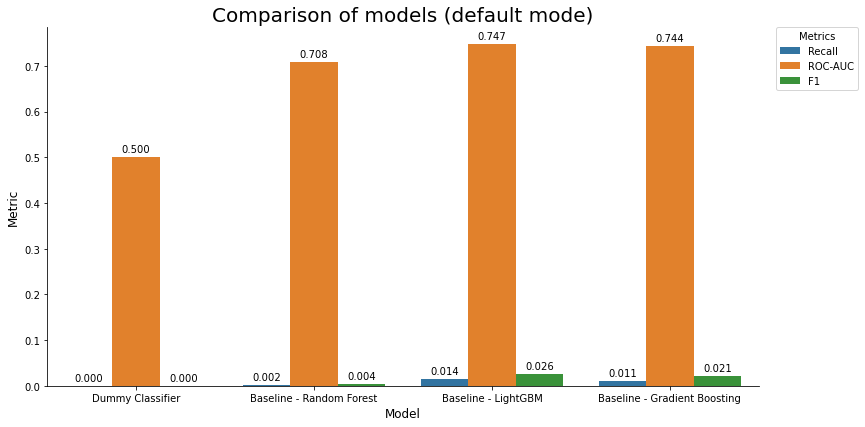

In [180]:
fig, ax1 = plt.subplots(figsize=(12, 6))
plot = sns.barplot(x="Model", y="Value", hue="Metric", data=df_models_metrics_reduced, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("Comparison of models (default mode)", size=20)
plt.legend(bbox_to_anchor=(1.14, 1), borderaxespad=0, title="Metrics")
plt.tight_layout()
plt.xlabel("Model", size=12)
plt.ylabel("Metric", size=12)
sns.despine(fig)


<div class="alert alert-info" role="alert">
 <h3>Data sampling, tuning models::</h3>

</div>

Maintenant, nous allons faire un sous-échantillon de l'ensemble de données pour ajuster certains paramètres avant la modélisation:
  
  - Data sampling
  
  - Tuning models

In [181]:
df_subsample = data3.copy()
df_subsample = df_subsample.sample(frac=0.5)

In [182]:
df_subsample

,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_9,FLAG_DOCUMENT_21,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_OWN_REALTY,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_12,AMT_CREDIT,AMT_INCOME_TOTAL,FLAG_PHONE,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,TARGET,REG_CITY_NOT_LIVE_CITY,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,REG_REGION_NOT_LIVE_REGION,HOUR_APPR_PROCESS_START,WEEKDAY_APPR_PROCESS_START,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,FLAG_EMAIL,FLAG_CONT_MOBILE,ORGANIZATION_TYPE,FLAG_WORK_PHONE,FLAG_EMP_PHONE,FLAG_MOBIL,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_BIRTH,REGION_POPULATION_RELATIVE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE,SK_ID_CURR
134103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unaccompanied,0.0,0.0,0.0,0.0,0.114720,225000.0,16803.0,2.0,-985.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0,0,0,0,272520.0,90000.0,0,1,1,0,0,0,0,0,12,WEDNESDAY,3,3,0,1,Self-employed,0,1,1,-771,-396.0,-390,-9780,0.020713,House / apartment,Married,Secondary / secondary special,Working,255527
196354,0.052393,0.0,0.0,NaN,0.0,0.0,1.0,Unaccompanied,0.0,0.0,0.0,0.0,0.480266,405000.0,27360.0,1.0,-590.0,0,0,Cash loans,M,N,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,533304.0,270000.0,0,0,1,0,1,0,0,0,10,SATURDAY,3,3,0,1,Security Ministries,0,1,1,-730,-2775.0,-552,-8060,0.020713,House / apartment,Single / not married,Secondary / secondary special,State servant,327671
114693,0.252599,0.0,0.0,0.0,1.0,0.0,0.0,Unaccompanied,2.0,NaN,2.0,NaN,0.300653,450000.0,18135.0,2.0,-3.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,N,0,0,0,0,0,1,0,1,0,687600.0,112500.0,0,1,1,0,0,0,0,0,18,MONDAY,2,2,0,1,Business Entity Type 3,0,1,1,-3891,-5893.0,-2404,-15966,0.024610,Municipal apartment,Married,Secondary / secondary special,Working,232996
115188,0.678568,0.0,0.0,0.0,0.0,0.0,2.0,Unaccompanied,0.0,0.0,0.0,0.0,0.665134,405000.0,20250.0,2.0,-2671.0,0,0,Revolving loans,M,Y,0,0,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,405000.0,202500.0,0,0,0,0,0,0,1,1,18,TUESDAY,1,1,0,1,Business Entity Type 3,0,1,1,-3715,-33.0,-1774,-20328,0.011657,House / apartment,Married,Secondary / secondary special,Working,233577
7499,0.477649,0.0,0.0,0.0,1.0,0.0,1.0,Unaccompanied,0.0,0.0,0.0,0.0,0.575663,1125000.0,33025.5,2.0,0.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,1125000.0,135000.0,0,0,0,0,0,0,0,0,9,FRIDAY,2,2,0,1,Self-employed,0,1,1,-1375,-10606.0,-1265,-17834,0.025164,House / apartment,Married,Secondary / secondary special,Working,108745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209292,0.438281,0.0,0.0,0.0,0.0,2.0,3.0,Unaccompanied,0.0,0.0,0.0,0.0,0.687041,900000.0,32328.0,2.0,-1710.0,0,0,Cash loans,F,N,0,1,0,0,0,0,0,0,0,0,N,0,0,0,0,0,0,0,0,0,900000.0,135000.0,0,0,0,0,0,0,0,0,19,SATURDAY,2,2,0,1,Business Entity Type 3,1,1,1,-608,-3414.0,-3102,-17055,0.024610,House / apartment,Married,Secondary / secondary special,Working,342574
66775,0.773896,0.0,0.0,0.0,0.0,0.0,5.0,Family,0.0,0.0,0.0,0.0,0.629873,117000.0,15070.5,2.0,-1232.0,0,0,Cash loans,M,Y,0,0,0,0,1,0,0,0,0,0,Y,0,0,0,0,0,0,0,0,0,132444.0,121500.0,0,0,0,0,0,0,0,0,11,FRIDAY,2,2,0,1,XNA,0,0,1,-4398,-10027.0,365243,-23607,0.010147,

In [183]:
# separate target out of features "predictors"
X_ss  = df_subsample.drop(["TARGET", "SK_ID_CURR"], axis=1)
y_target_ss  = df_subsample['TARGET']

X_ss_=preprocessor.fit_transform(X_ss)
X_ss = pd.DataFrame(X_ss_, index=X_ss.index, columns=X_ss.columns)

# data splitting
# données d'entraînement et données de validation
X_train_ss, X_test_ss, y_train_ss, y_test_ss  = train_test_split(X_ss, y_target_ss, train_size=0.8, stratify=y_target_ss, random_state=42)


#X_train_ss=preprocessor.fit_transform(X_train_ss)
#X_test_ss=preprocessor.fit_transform(X_test_ss)


Nous allons à présent visualiser l'impact des hyperparamètres de la GridSearch :

##### --- HalvingGridSearchCV (Optimisation des hyperparamètres )---

In [185]:
# hyperparamètres permettant d'améliorer la performance des algorithmes de ML

for k, v in classifiers.items():
    reg = make_pipeline(v)
    print("{}\n-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -\n".format(sorted(reg.get_params().keys())))


['dummyclassifier', 'dummyclassifier__constant', 'dummyclassifier__random_state', 'dummyclassifier__strategy', 'memory', 'steps', 'verbose']
-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -

['memory', 'randomforestclassifier', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start', 'steps', 'verbose']
-  -  -  -  -  -  -  -  -

In [186]:
#Définir les paramètres de GSearch-CV pour les algorithmes qui ont la meilleure performance (RF et XGBOOST):


param_grid_RF = {
    "randomforestclassifier__max_depth" : [20,25,30], # The maximum depth of the tree.
    #"randomforestclassifier__max_features" : ["auto", "sqrt"], # The number of features to consider when looking for the best split.
    #"randomforestclassifier__min_samples_leaf" : [1], # The minimum number of samples required to be at a leaf node.
    #"randomforestclassifier__min_samples_split" : [2], # The minimum number of samples required to split an internal node.
    "randomforestclassifier__n_estimators" : [100,300,500] # The number of trees in the forest.
}

param_grid_XGBOOST = {
    "gradientboostingregressor__learning_rate" : [0.08,0.09], # Learning rate shrinks the contribution of each tree by learning_rate.
    "gradientboostingregressor__max_depth" : [6,7], # Maximum depth of the individual regression estimators. 
    "gradientboostingregressor__n_estimators" : [1750], # The number of boosting stages to perform. 
    "gradientboostingregressor__subsample" : [0.9,1] # The fraction of samples to be used for fitting the individual base learners.
    #"gradientboostingregressor__max_features": ["auto","sqrt" ] # The number of features to consider when looking for the best split.
}

- Random Forest

In [187]:
# Optimisation des hyperparamètres de RandomForest
start_time_model = timeit.default_timer()

param_grid ={
             'max_depth': [8],
             #'max_features': ['auto', 'sqrt'],
             #'min_samples_leaf': [1, 2, 4],
             #'min_samples_split': [2, 5, 10],
             'n_estimators': [100]
            }
#26   500

clf_rf = RandomForestClassifier(random_state=42)
search_rf = HalvingGridSearchCV(clf_rf, param_grid, scoring="roc_auc", cv=stratified_kfold, n_jobs=-1)
search_rf.fit(X_train_ss, y_train_ss)

print("Best ROC-AUC score: {}".format(search_rf.best_score_))
print("Best params: {}".format(search_rf.best_params_))

rf_parameters = search_rf.best_params_

end_time_model =  round(timeit.default_timer() - start_time_model, 3)
print('---------- Temps total d\'optimisation = '+str(end_time_model)+' seconds ----------\n\n')

Best ROC-AUC score: 0.7323472701865561
Best params: {'max_depth': 8, 'n_estimators': 100}
---------- Temps total d'optimisation = 48.278 seconds ----------




- XGBOOST

In [102]:
# Optimisation des hyperparamètres de LightGBM
start_time_model = timeit.default_timer()

param_grid ={
    'max_depth': [4],
    'max_features': [38],
    'n_estimators': [25]
            }
clf_gb = GradientBoostingClassifier(validation_fraction=0.2, 
                                    n_iter_no_change=5,
                                    tol=0.01,
                                    random_state=42)
search_gb = HalvingGridSearchCV(clf_gb, param_grid, scoring="roc_auc", cv=stratified_kfold, n_jobs=-1)
search_gb.fit(X_train_ss, y_train_ss)

print("Best ROC-AUC score: {}".format(search_gb.best_score_))
print("Best params: {}".format(search_gb.best_params_))

gb_parameters = search_gb.best_params_


end_time_model =  round(timeit.default_timer() - start_time_model, 3)
print('---------- Temps total d\'optimisation = '+str(end_time_model)+' seconds ----------\n\n')

Best ROC-AUC score: 0.7211066207964983
Best params: {'max_depth': 4, 'max_features': 38, 'n_estimators': 25}
---------- Temps total d'optimisation = 14.344 seconds ----------




- LightGBM

Best ROC-AUC score: 0.7423383133245735
Best params: {'max_depth': 10, 'n_estimators': 65, 'num_leaves': 16}
---------- Temps total d'optimisation = 7.866 seconds ----------


Overall Accuracy: 0.919
Overall Precision: 0.695
Overall Recall: 0.504
F1 score: 0.488
loss: 0.007

Matrice de confusion:
 [[28237    26]
 [ 2465    23]]


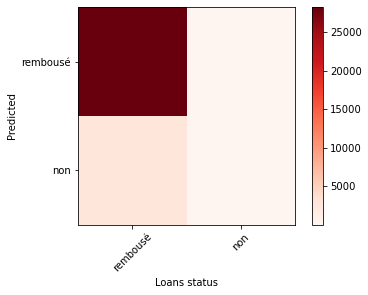

In [163]:
# Optimisation des hyperparamètres de LightGBM
start_time_model = timeit.default_timer()

param_grid ={
        "n_estimators" : [65],
    "num_leaves" : [16], 
    "max_depth" : [10]
}

clf_lgbm = LGBMClassifier(random_state=42)
search_lgbm = HalvingGridSearchCV(clf_lgbm, param_grid, scoring="roc_auc", cv=stratified_kfold, n_jobs=-1 )
search_lgbm .fit(X_train_ss, y_train_ss)

print("Best ROC-AUC score: {}".format(search_lgbm.best_score_))
print("Best params: {}".format(search_lgbm.best_params_))

lgbm_parameters = search_lgbm.best_params_


end_time_model =  round(timeit.default_timer() - start_time_model, 3)
print('---------- Temps total d\'optimisation = '+str(end_time_model)+' seconds ----------\n\n')



# Obtenir les scores de probabilité de classe
#y_prob = search_lgbm.predict_proba(X_test_ss)
y_prob = search_lgbm.predict_proba(X_test_ss)[:, 1]
# y_prob = search_lgbm.predict(X_test_ss)
y_pred = search_lgbm.predict(X_test_ss)


# metrics

print("Overall Accuracy:", round(accuracy_score(
    y_test_ss, y_pred), 3))
print("Overall Precision:", round(precision_score(
    y_test_ss, y_pred, average='macro'), 3))
print("Overall Recall:", round(recall_score(
    y_test_ss, y_pred, average='macro'), 3))

print("F1 score:", round(f1_score(
    y_test_ss, y_pred, average='macro'), 3))
    
print("loss:", round(custom_score(
    y_test_ss, y_pred), 3))

"""auc = round(roc_auc_score(y_test_ss, y_prob), 3)
print('Average AUC:', auc, '\n')"""


# Confusion matrix
loans_classes = ['rembousé','non']
mcm = confusion_matrix(y_test_ss, y_pred)
print('\nMatrice de confusion:\n', mcm)
plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Reds, )
plt.colorbar()
"""disp = ConfusionMatrixDisplay(confusion_matrix=mcm,
                               display_labels=loans_classes)
disp.plot()"""
tick_marks = np.arange(len(loans_classes))
plt.xticks(tick_marks, loans_classes, rotation=45)
plt.yticks(tick_marks, loans_classes)
plt.xlabel("Loans status")
plt.ylabel("Predicted")
plt.show()


<div class="alert alert-info" role="alert">
 <h3>Class weight:</h3>

</div>

Modélisation à l'aide de class_weight:

Testons le paramètre 'class_weight' pour affecter le calcul du modèle afin de pénaliser différemment une fausse classification de la classe minoritaire et majoritaire

RF:

In [201]:
clf_rf_cw = RandomForestClassifier(**rf_parameters,
                                   class_weight="balanced",
                                   random_state=42,
                                   n_jobs=-1)

start_time_model = timeit.default_timer()

clf_rf_cw.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

X_val_=preprocessor.fit_transform(X_val)
X_val = pd.DataFrame(X_val_, index=X_val.index, columns=X_val.columns)
X_val

,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_9,FLAG_DOCUMENT_21,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_OWN_REALTY,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_12,AMT_CREDIT,AMT_INCOME_TOTAL,FLAG_PHONE,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,REG_REGION_NOT_LIVE_REGION,HOUR_APPR_PROCESS_START,WEEKDAY_APPR_PROCESS_START,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,FLAG_EMAIL,FLAG_CONT_MOBILE,ORGANIZATION_TYPE,FLAG_WORK_PHONE,FLAG_EMP_PHONE,FLAG_MOBIL,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_BIRTH,REGION_POPULATION_RELATIVE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE
180595,0.602536,0.0,0.0,0.0,0.000000,0.0,0.142857,0.000,0.0,0.000,0.0,0.880680,0.253521,0.833935,0.333333,0.549550,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.256979,0.260433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217391,0.5,0.5,0.0,1.0,0.0,1.0,0.0,0.488576,0.158748,0.045186,0.316519,0.304923,1.000000,0.0,1.0,1.0,0.0,0.333333,0.087719,0.2,0.2,1.00,1.000000
186424,0.431348,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.000,0.0,0.780555,0.374648,0.459419,0.333333,0.265911,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.383291,0.207607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.608696,0.5,0.5,0.0,1.0,0.0,1.0,0.0,0.469085,0.970102,0.039054,0.827561,0.406418,1.000000,0.0,1.0,1.0,1.0,0.833333,0.087719,0.2,0.2,1.00,1.000000
103500,0.214108,0.0,0.0,0.0,0.333333,0.0,0.285714,0.000,0.0,0.000,0.0,0.521007,0.256338,0.280625,0.333333,0.660564,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.283653,0.339672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.391304,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.569899,0.848261,0.043135,0.721769,0.431479,1.000000,0.0,0.0,0.0,1.0,0.166667,0.087719,0.2,0.2,0.25,1.000000
133153,0.861336,0.0,0.0,0.0,0.000000,0.0,0.142857,0.000,0.0,0.000,0.0,0.413499,0.647887,0.498392,0.333333,0.678582,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.676814,0.101955,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.695652,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.590669,0.463576,0.041583,0.352297,0.386893,1.000000,0.0,0.0,0.0,0.0,0.833333,0.736842,0.2,0.0,1.00,1.000000
211902,0.450630,0.0,0.0,0.0,0.000000,0.0,0.428571,0.000,0.0,0.000,0.0,0.319953,0.318310,0.434027,0.333333,0.654461,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.326110,0.086107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.521739,0.5,0.5,0.0,1.0,0.0,1.0,0.0,0.745007,0.272552,0.024025,0.408559,0.399851,1.000000,0.0,0.0,0.0,1.0,1.000000,0.526316,0.4,0.2,1.00,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16213,0.431348,0.0,0.0,0.0,0.000000,0.0,0.000000,0.500,1.0,0.500,0.0,0.701615,0.422535,0.374910,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.448088,0.160063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.478261,0.5,0.5,0.0,1.0,0.0,0.0,0.0,0.369069,0.509355,1.000000,0.245078,0.483551,1.000000,0.0,0.0,0.0,1.0,1.000000,1.000000,0.2,1.0,1.00,0.428571
294620,0.106515,0.0,0.0,0.0,0.333333,0.5,0.142857,0.

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Best ROC-AUC: 0.732
Overall Accuracy: 0.73
Overall Precision: 0.561
Overall Recall: 0.667
F1 score: 0.548
loss: 0.058

Matrice de confusion:
 [[41963 14574]
 [ 2026  2939]]


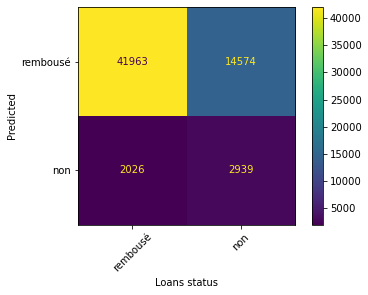

In [202]:
# Obtenir les scores de probabilité de classe
#y_prob = search_lgbm.predict_proba(X_val_)
y_prob = clf_rf_cw.predict_proba(X_val_)[:, 1]
# y_prob = search_lgbm.predict(X_val_)
y_pred = clf_rf_cw.predict(X_val_)


# metrics
roc_auc_ = round(roc_auc_score(y_val, y_prob), 3)
print('Best ROC-AUC: {}'.format(roc_auc_))

accuracy_score_= round(accuracy_score(y_val, y_pred), 3)
print("Overall Accuracy:", accuracy_score_)

precision_score_= round(precision_score(y_val, y_pred, average='macro'), 3)
print("Overall Precision:", precision_score_)

recall_score_= round(recall_score(y_val, y_pred, average='macro'), 3)
print("Overall Recall:",recall_score_)

f1_score_= round(f1_score(y_val, y_pred, average='macro'), 3)
print("F1 score:",f1_score_)

loss_score_= round(custom_score(y_val, y_pred), 3)
print("loss:", loss_score_)

"""auc = round(roc_auc_score(X_val_, y_prob), 3)
print('Average AUC:', auc, '\n')"""


# Confusion matrix
loans_classes = ['rembousé','non']
mcm = confusion_matrix(y_val, y_pred)
print('\nMatrice de confusion:\n', mcm)
"""plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Reds, )
plt.colorbar()"""
disp = ConfusionMatrixDisplay(confusion_matrix=mcm,
                               display_labels=loans_classes)
disp.plot()
tick_marks = np.arange(len(loans_classes))
plt.xticks(tick_marks, loans_classes, rotation=45)
plt.yticks(tick_marks, loans_classes)
plt.xlabel("Loans status")
plt.ylabel("Predicted")
plt.show()

In [203]:
df_models_metrics_complete = pd.DataFrame({
    "Model" : ["Class weight - Random Forest"],
    "ROC-AUC" : roc_auc_,    
    "Overall Accuracy" : accuracy_score_,
    "Overall Precision" : precision_score_,
    "Overall Recall" : recall_score_,
    "F1 score" : f1_score_, 
    "Loss score": loss_score_,
    "Duration" : round(end_time_model/60, 1)
})


In [204]:
df_models_metrics_complete

,Model,ROC-AUC,Overall Accuracy,Overall Precision,Overall Recall,F1 score,Loss score,Duration
0,Class weight - Random Forest,0.732,0.73,0.561,0.667,0.548,0.058,0.4


LGBM:

Best ROC-AUC: 0.751
Overall Accuracy: 0.722
Overall Precision: 0.565
Overall Recall: 0.685
F1 score: 0.55
loss: 0.08

Matrice de confusion:
 [[41211 15326]
 [ 1783  3182]]


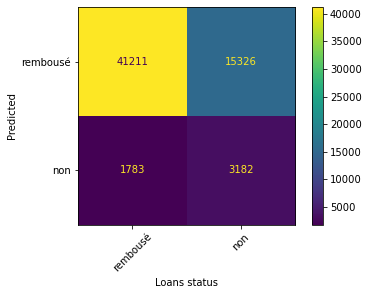

In [205]:
clf_lgbm_cw = LGBMClassifier(**lgbm_parameters, class_weight="balanced", learning_rate=0.15,
                             objective='binary', subsample=0.8,
                             reg_alpha=0.1, reg_lambda=0.1,
                             min_split_gain=0.02, min_child_weight=37,
                             random_state=42, n_jobs=-1)

start_time_model = timeit.default_timer()

clf_lgbm_cw.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

# Obtenir les scores de probabilité de classe
#y_prob = search_lgbm.predict_proba(X_val_)
y_prob = clf_lgbm_cw.predict_proba(X_val_)[:, 1]
# y_prob = search_lgbm.predict(X_val_)
y_pred = clf_lgbm_cw.predict(X_val_)


# Obtenir les scores de probabilité de classe
#y_prob = search_lgbm.predict_proba(X_val_)
y_prob = clf_lgbm_cw.predict_proba(X_val_)[:, 1]
# y_prob = search_lgbm.predict(X_val_)
y_pred = clf_lgbm_cw.predict(X_val_)


# metrics
roc_auc_ = round(roc_auc_score(y_val, y_prob), 3)
print('Best ROC-AUC: {}'.format(roc_auc_))

accuracy_score_= round(accuracy_score(y_val, y_pred), 3)
print("Overall Accuracy:", accuracy_score_)

precision_score_= round(precision_score(y_val, y_pred, average='macro'), 3)
print("Overall Precision:", precision_score_)

recall_score_= round(recall_score(y_val, y_pred, average='macro'), 3)
print("Overall Recall:",recall_score_)

f1_score_= round(f1_score(y_val, y_pred, average='macro'), 3)
print("F1 score:",f1_score_)

loss_score_= round(custom_score(y_val, y_pred), 3)
print("loss:", loss_score_)

"""auc = round(roc_auc_score(X_val_, y_prob), 3)
print('Average AUC:', auc, '\n')"""


# Confusion matrix
loans_classes = ['rembousé','non']
mcm = confusion_matrix(y_val, y_pred)
print('\nMatrice de confusion:\n', mcm)
"""plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Reds, )
plt.colorbar()"""
disp = ConfusionMatrixDisplay(confusion_matrix=mcm,
                               display_labels=loans_classes)
disp.plot()
tick_marks = np.arange(len(loans_classes))
plt.xticks(tick_marks, loans_classes, rotation=45)
plt.yticks(tick_marks, loans_classes)
plt.xlabel("Loans status")
plt.ylabel("Predicted")
plt.show()

In [206]:
df_temp  = pd.DataFrame({
    "Model" : ["Class weight - LightGBM"],
    "ROC-AUC" : roc_auc_,    
    "Overall Accuracy" : accuracy_score_,
    "Overall Precision" : precision_score_,
    "Overall Recall" : recall_score_,
    "F1 score" : f1_score_,  
    "Loss score": loss_score_,
    "Duration" : round(end_time_model/60, 1)
})


In [207]:
df_models_metrics_complete = pd.concat([df_models_metrics_complete, df_temp])
df_models_metrics_complete.reset_index(drop=True)
df_models_metrics_complete

,Model,ROC-AUC,Overall Accuracy,Overall Precision,Overall Recall,F1 score,Loss score,Duration
0,Class weight - Random Forest,0.732,0.730,0.561,0.667,0.548,0.058,0.4
0,Class weight - LightGBM,0.751,0.722,0.565,0.685,0.550,0.080,0.1


G-BOOST:

 Gradient Boosting (GBM) n'a pas d'appel de paramètres 'class_weight' à traiter avec la classe déséquilibrée.

Mais, GBM traite le déséquilibre de classe en construisant des ensembles d'apprentissage successifs basés sur des exemples mal classés

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names


Best ROC-AUC: 0.731
Overall Accuracy: 0.919
Overall Precision: 0.96
Overall Recall: 0.5
F1 score: 0.48
loss: 0.001

Matrice de confusion:
 [[56537     0]
 [ 4962     3]]


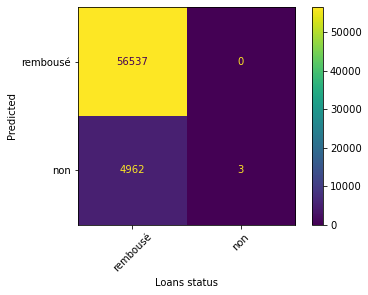

In [208]:
clf_gb_cw = GradientBoostingClassifier(**gb_parameters, 
                                       validation_fraction=0.2, 
                                       #n_iter_no_change=5,
                                       #tol=0.01,
                                       random_state=42)

start_time_model = timeit.default_timer()

clf_gb_cw.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)

# Obtenir les scores de probabilité de classe
#y_prob = search_lgbm.predict_proba(X_val_)
y_prob = clf_gb_cw.predict_proba(X_val_)[:, 1]
# y_prob = search_lgbm.predict(X_val_)
y_pred = clf_gb_cw.predict(X_val_)


# Obtenir les scores de probabilité de classe
#y_prob = search_lgbm.predict_proba(X_val_)
y_prob = clf_gb_cw.predict_proba(X_val_)[:, 1]
# y_prob = search_lgbm.predict(X_val_)
y_pred = clf_gb_cw.predict(X_val_)


# metrics
roc_auc_ = round(roc_auc_score(y_val, y_prob), 3)
print('Best ROC-AUC: {}'.format(roc_auc_))

accuracy_score_= round(accuracy_score(y_val, y_pred), 3)
print("Overall Accuracy:", accuracy_score_)

precision_score_= round(precision_score(y_val, y_pred, average='macro'), 3)
print("Overall Precision:", precision_score_)

recall_score_= round(recall_score(y_val, y_pred, average='macro'), 3)
print("Overall Recall:",recall_score_)

f1_score_= round(f1_score(y_val, y_pred, average='macro'), 3)
print("F1 score:",f1_score_)

loss_score_= round(custom_score(y_val, y_pred), 3)
print("loss:", loss_score_)

"""auc = round(roc_auc_score(X_val_, y_prob), 3)
print('Average AUC:', auc, '\n')"""


# Confusion matrix
loans_classes = ['rembousé','non']
mcm = confusion_matrix(y_val, y_pred)
print('\nMatrice de confusion:\n', mcm)
"""plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Reds, )
plt.colorbar()"""
disp = ConfusionMatrixDisplay(confusion_matrix=mcm,
                               display_labels=loans_classes)
disp.plot()
tick_marks = np.arange(len(loans_classes))
plt.xticks(tick_marks, loans_classes, rotation=45)
plt.yticks(tick_marks, loans_classes)
plt.xlabel("Loans status")
plt.ylabel("Predicted")
plt.show()

In [209]:
df_temp  = pd.DataFrame({
    "Model" : ["optimized - G-BOOST"],
    "ROC-AUC" : roc_auc_,    
    "Overall Accuracy" : accuracy_score_,
    "Overall Precision" : precision_score_,
    "Overall Recall" : recall_score_,
    "F1 score" : f1_score_,    
    "Loss score": loss_score_,
    "Duration" : round(end_time_model/60, 1)
})

In [210]:
df_models_metrics_complete = pd.concat([df_models_metrics_complete, df_temp])
df_models_metrics_complete.reset_index(drop=True)
df_models_metrics_complete

,Model,ROC-AUC,Overall Accuracy,Overall Precision,Overall Recall,F1 score,Loss score,Duration
0,Class weight - Random Forest,0.732,0.730,0.561,0.667,0.548,0.058,0.4
0,Class weight - LightGBM,0.751,0.722,0.565,0.685,0.550,0.080,0.1
0,optimized - G-BOOST,0.731,0.919,0.960,0.500,0.480,0.001,0.6



<div class="alert alert-info" role="alert">
 <h3>SMOTE:</h3>

</div>

OverSampling:
   
   - SMOTE

In [212]:
# RandomForest

clf_rf_os = imbpipeline(steps = [["Smote", smote],
                                 ["Random_Forest",
                                  RandomForestClassifier(**rf_parameters,random_state=42,n_jobs=-1)]])

class_weight="balanced",
            
start_time_model = timeit.default_timer()

clf_rf_os.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Best ROC-AUC: 0.683
Overall Accuracy: 0.789
Overall Precision: 0.546
Overall Recall: 0.595
F1 score: 0.548
loss: 0.005

Matrice de confusion:
 [[46718  9819]
 [ 3155  1810]]


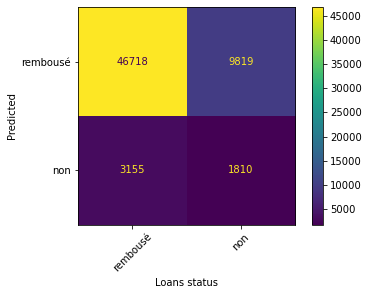

In [213]:
# Obtenir les scores de probabilité de classe
#y_prob = search_lgbm.predict_proba(X_val_)
y_prob = clf_rf_os.predict_proba(X_val_)[:, 1]
# y_prob = search_lgbm.predict(X_val_)
y_pred = clf_rf_os.predict(X_val_)


# metrics
roc_auc_ = round(roc_auc_score(y_val, y_prob), 3)
print('Best ROC-AUC: {}'.format(roc_auc_))

accuracy_score_= round(accuracy_score(y_val, y_pred), 3)
print("Overall Accuracy:", accuracy_score_)

precision_score_= round(precision_score(y_val, y_pred, average='macro'), 3)
print("Overall Precision:", precision_score_)

recall_score_= round(recall_score(y_val, y_pred, average='macro'), 3)
print("Overall Recall:",recall_score_)

f1_score_= round(f1_score(y_val, y_pred, average='macro'), 3)
print("F1 score:",f1_score_)

loss_score_= round(custom_score(y_val, y_pred), 3)
print("loss:", loss_score_)


"""auc = round(roc_auc_score(X_val_, y_prob), 3)
print('Average AUC:', auc, '\n')"""


# Confusion matrix
loans_classes = ['rembousé','non']
mcm = confusion_matrix(y_val, y_pred)
print('\nMatrice de confusion:\n', mcm)
"""plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Reds, )
plt.colorbar()"""
disp = ConfusionMatrixDisplay(confusion_matrix=mcm,
                               display_labels=loans_classes)
disp.plot()
tick_marks = np.arange(len(loans_classes))
plt.xticks(tick_marks, loans_classes, rotation=45)
plt.yticks(tick_marks, loans_classes)
plt.xlabel("Loans status")
plt.ylabel("Predicted")
plt.show()

In [214]:
df_temp  = pd.DataFrame({
    "Model" : ["SMOTE - Random Forest"],
    "ROC-AUC" : roc_auc_,    
    "Overall Accuracy" : accuracy_score_,
    "Overall Precision" : precision_score_,
    "Overall Recall" : recall_score_,
    "F1 score" : f1_score_,    
    "Loss score": loss_score_,
    "Duration" : round(end_time_model/60, 1)
})


In [215]:
df_models_metrics_complete = pd.concat([df_models_metrics_complete, df_temp])
df_models_metrics_complete.reset_index(drop=True)
df_models_metrics_complete

,Model,ROC-AUC,Overall Accuracy,Overall Precision,Overall Recall,F1 score,Loss score,Duration
0,Class weight - Random Forest,0.732,0.730,0.561,0.667,0.548,0.058,0.4
0,Class weight - LightGBM,0.751,0.722,0.565,0.685,0.550,0.080,0.1
0,optimized - G-BOOST,0.731,0.919,0.960,0.500,0.480,0.001,0.6
0,SMOTE - Random Forest,0.683,0.789,0.546,0.595,0.548,0.005,0.9


Best ROC-AUC: 0.714
Overall Accuracy: 0.911
Overall Precision: 0.604
Overall Recall: 0.527
F1 score: 0.532
loss: 0.037

Matrice de confusion:
 [[55677   860]
 [ 4623   342]]


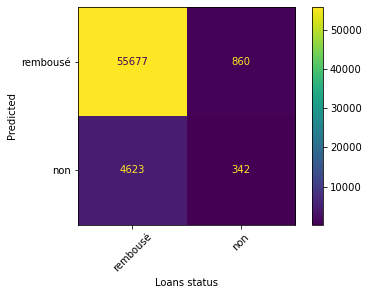

In [216]:
#LGBM

clf_lgbm_os = imbpipeline(steps = [["Smote", smote],
                                   ["LightGBM", LGBMClassifier(**lgbm_parameters, learning_rate=0.15,
                                                               objective='binary', subsample=0.8,
                                                               reg_alpha=0.1, reg_lambda=0.1,
                                                               min_split_gain=0.02, min_child_weight=37,
                                                               random_state=42, n_jobs=-1)]
                                   ]
                          )


start_time_model = timeit.default_timer()

clf_lgbm_os.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)



# Obtenir les scores de probabilité de classe
#y_prob = search_lgbm.predict_proba(X_val_)
y_prob = clf_lgbm_os.predict_proba(X_val_)[:, 1]
# y_prob = search_lgbm.predict(X_val_)
y_pred = clf_lgbm_os.predict(X_val_)


# metrics
roc_auc_ = round(roc_auc_score(y_val, y_prob), 3)
print('Best ROC-AUC: {}'.format(roc_auc_))

accuracy_score_= round(accuracy_score(y_val, y_pred), 3)
print("Overall Accuracy:", accuracy_score_)

precision_score_= round(precision_score(y_val, y_pred, average='macro'), 3)
print("Overall Precision:", precision_score_)

recall_score_= round(recall_score(y_val, y_pred, average='macro'), 3)
print("Overall Recall:",recall_score_)

f1_score_= round(f1_score(y_val, y_pred, average='macro'), 3)
print("F1 score:",f1_score_)

loss_score_= round(custom_score(y_val, y_pred), 3)
print("loss:", loss_score_)

"""auc = round(roc_auc_score(X_val_, y_prob), 3)
print('Average AUC:', auc, '\n')"""


# Confusion matrix
loans_classes = ['rembousé','non']
mcm = confusion_matrix(y_val, y_pred)
print('\nMatrice de confusion:\n', mcm)
"""plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Reds, )
plt.colorbar()"""
disp = ConfusionMatrixDisplay(confusion_matrix=mcm,
                               display_labels=loans_classes)
disp.plot()
tick_marks = np.arange(len(loans_classes))
plt.xticks(tick_marks, loans_classes, rotation=45)
plt.yticks(tick_marks, loans_classes)
plt.xlabel("Loans status")
plt.ylabel("Predicted")
plt.show()

In [217]:
df_temp  = pd.DataFrame({
    "Model" : ["SMOTE - LightGBM"],
    "ROC-AUC" : roc_auc_,    
    "Overall Accuracy" : accuracy_score_,
    "Overall Precision" : precision_score_,
    "Overall Recall" : recall_score_,
    "F1 score" : f1_score_, 
    "Loss score": loss_score_,
    "Duration" : round(end_time_model/60, 1)
})

df_models_metrics_complete = pd.concat([df_models_metrics_complete, df_temp])
df_models_metrics_complete.reset_index(drop=True)
df_models_metrics_complete

,Model,ROC-AUC,Overall Accuracy,Overall Precision,Overall Recall,F1 score,Loss score,Duration
0,Class weight - Random Forest,0.732,0.730,0.561,0.667,0.548,0.058,0.4
0,Class weight - LightGBM,0.751,0.722,0.565,0.685,0.550,0.080,0.1
0,optimized - G-BOOST,0.731,0.919,0.960,0.500,0.480,0.001,0.6
0,SMOTE - Random Forest,0.683,0.789,0.546,0.595,0.548,0.005,0.9
0,SMOTE - LightGBM,0.714,0.911,0.604,0.527,0.532,0.037,0.2


X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names


Best ROC-AUC: 0.684
Overall Accuracy: 0.803
Overall Precision: 0.547
Overall Recall: 0.59
F1 score: 0.552
loss: 0.013

Matrice de confusion:
 [[47729  8808]
 [ 3299  1666]]


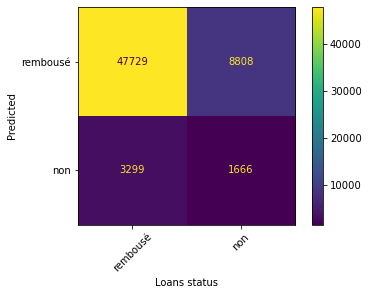

In [218]:
#G-BOOST

clf_gb_os = imbpipeline(steps = [["Smote", smote],
                                 ["Gradient Boosting", GradientBoostingClassifier(**gb_parameters,
                                                                                  validation_fraction=0.2, 
                                                                                  n_iter_no_change=5,
                                                                                  tol=0.01, random_state=42)]
                                ]
                       )

start_time_model = timeit.default_timer()

clf_gb_os.fit(X_train, y_train)

end_time_model =  round(timeit.default_timer() - start_time_model, 3)



# Obtenir les scores de probabilité de classe
#y_prob = search_lgbm.predict_proba(X_val_)
y_prob = clf_gb_os.predict_proba(X_val_)[:, 1]
# y_prob = search_lgbm.predict(X_val_)
y_pred = clf_gb_os.predict(X_val_)


# metrics
roc_auc_ = round(roc_auc_score(y_val, y_prob), 3)
print('Best ROC-AUC: {}'.format(roc_auc_))

accuracy_score_= round(accuracy_score(y_val, y_pred), 3)
print("Overall Accuracy:", accuracy_score_)

precision_score_= round(precision_score(y_val, y_pred, average='macro'), 3)
print("Overall Precision:", precision_score_)

recall_score_= round(recall_score(y_val, y_pred, average='macro'), 3)
print("Overall Recall:",recall_score_)

f1_score_= round(f1_score(y_val, y_pred, average='macro'), 3)
print("F1 score:",f1_score_)

loss_score_= round(custom_score(y_val, y_pred), 3)
print("loss:", loss_score_)

"""auc = round(roc_auc_score(X_val_, y_prob), 3)
print('Average AUC:', auc, '\n')"""


# Confusion matrix
loans_classes = ['rembousé','non']
mcm = confusion_matrix(y_val, y_pred)
print('\nMatrice de confusion:\n', mcm)
"""plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Reds, )
plt.colorbar()"""
disp = ConfusionMatrixDisplay(confusion_matrix=mcm,
                               display_labels=loans_classes)
disp.plot()
tick_marks = np.arange(len(loans_classes))
plt.xticks(tick_marks, loans_classes, rotation=45)
plt.yticks(tick_marks, loans_classes)
plt.xlabel("Loans status")
plt.ylabel("Predicted")
plt.show()



In [219]:
df_temp  = pd.DataFrame({
    "Model" : ["SMOTE - G-BOOST"],
    "ROC-AUC" : roc_auc_,    
    "Overall Accuracy" : accuracy_score_,
    "Overall Precision" : precision_score_,
    "Overall Recall" : recall_score_,
    "F1 score" : f1_score_,    
    "Loss score": loss_score_,
    "Duration" : round(end_time_model/60, 1)
})

df_models_metrics_complete = pd.concat([df_models_metrics_complete, df_temp])
df_models_metrics_complete.reset_index(drop=True)
df_models_metrics_complete

,Model,ROC-AUC,Overall Accuracy,Overall Precision,Overall Recall,F1 score,Loss score,Duration
0,Class weight - Random Forest,0.732,0.730,0.561,0.667,0.548,0.058,0.4
0,Class weight - LightGBM,0.751,0.722,0.565,0.685,0.550,0.080,0.1
0,optimized - G-BOOST,0.731,0.919,0.960,0.500,0.480,0.001,0.6
0,SMOTE - Random Forest,0.683,0.789,0.546,0.595,0.548,0.005,0.9
0,SMOTE - LightGBM,0.714,0.911,0.604,0.527,0.532,0.037,0.2
0,SMOTE - G-BOOST,0.684,0.803,0.547,0.590,0.552,0.013,1.3


Comparaison des modèles:

In [220]:
df_models_metrics_complete = pd.melt(df_models_metrics_complete[["Model", "ROC-AUC",
                                                                 "Overall Accuracy",
                                                                 "Overall Precision",
                                                                 "Overall Recall",
                                                                 "Loss score",
                                                                 "F1 score"]]
                                     , id_vars="Model", var_name="Metric", value_name="Value")
df_models_metrics_complete.head()

,Model,Metric,Value
0,Class weight - Random Forest,ROC-AUC,0.732
1,Class weight - LightGBM,ROC-AUC,0.751
2,optimized - G-BOOST,ROC-AUC,0.731
3,SMOTE - Random Forest,ROC-AUC,0.683
4,SMOTE - LightGBM,ROC-AUC,0.714


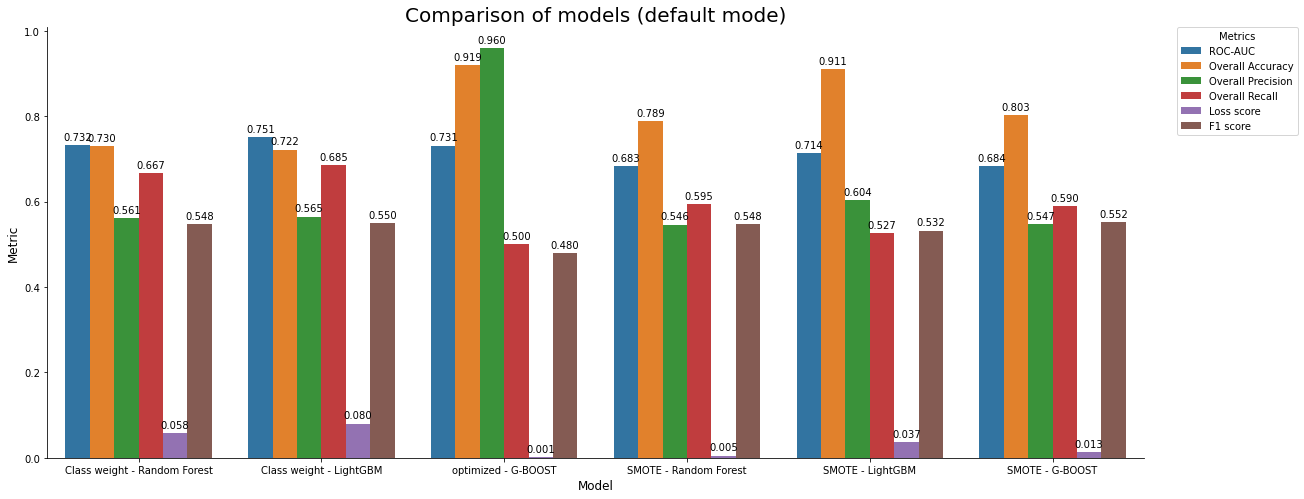

In [221]:
fig, ax1 = plt.subplots(figsize=(18, 7))
plot = sns.barplot(x="Model", y="Value", hue="Metric", data=df_models_metrics_complete, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("Comparison of models (default mode)", size=20)
plt.legend(bbox_to_anchor=(1.14, 1), borderaxespad=0, title="Metrics")
plt.tight_layout()
plt.xlabel("Model", size=12)
plt.ylabel("Metric", size=12)
sns.despine(fig)

Sauvegarder le meilleur modèle:

Nous utiliserons joblib pour enregistrer notre modèle dans un fichier pickle (.pkl).

Cela facilite l'utilisation du modèle à l'avenir sans répéter le processus d'entraînement. 

In [125]:
# Enregistrement du modèle optimisé (energy)
joblib.dump(clf_lgbm_cw, "LGBM_P7.pkl")

['LGBM_P7.pkl']


<div class="alert alert-info" role="alert">
 <h3>Interprétabilité du modèle:</h3>

</div>

 Interprétabilité du modèle:


Features importance:
 - Features importance pour meilleur Algorithme LGBM:

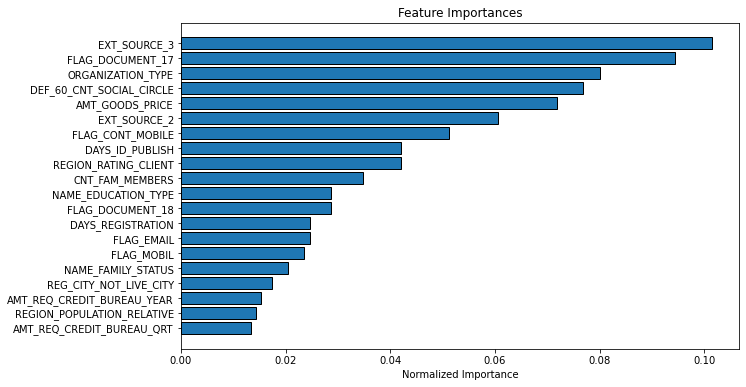

In [127]:
# Make the feature importance dataframe
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': clf_lgbm_cw.feature_importances_})

fi_sorted = plot_feature_importances(feature_importances)

Interprétation locale:

Pour faire l'interprétation locale, nous allons utiliser SHAP

La méthode SHAP (SHapley Additive exPlanations) consiste à calculer la valeur de Shapley pour toutes les variables de tous les individus c’est-à-dire la moyenne de l’impact d’une variable (sur la sortie, donc la prédiction) pour toutes les combinaisons de variables possibles.
La somme des effets de chaque variable expliquera la prédiction.

Summary plot:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


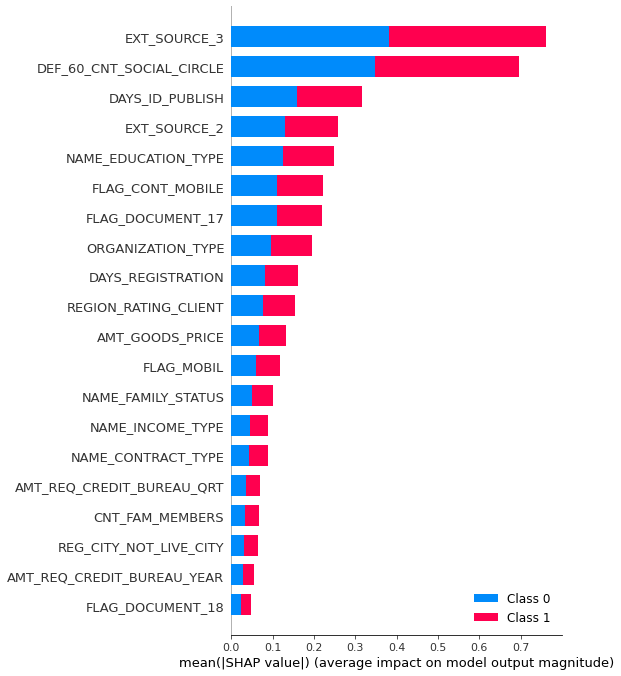

In [128]:
explainer = shap.TreeExplainer(clf_lgbm_cw)
shap_values = explainer.shap_values(X_val_)
# Summary plot
shap.summary_plot(shap_values, X_val)

Summary plot :

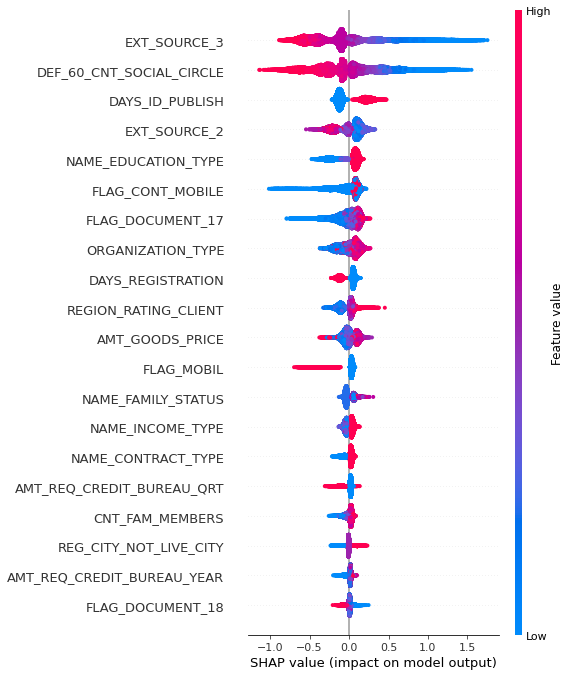

In [129]:
shap.summary_plot(shap_values[1], X_val, show=False)


In [130]:
X_val_=preprocessor.fit_transform(X_val)

X_val = pd.DataFrame(X_val_, index=X_val.index, columns=X_val.columns)
X_val

,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN,FLAG_DOCUMENT_8,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_9,FLAG_DOCUMENT_21,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_OWN_REALTY,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_12,AMT_CREDIT,AMT_INCOME_TOTAL,FLAG_PHONE,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,REG_REGION_NOT_LIVE_REGION,HOUR_APPR_PROCESS_START,WEEKDAY_APPR_PROCESS_START,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,FLAG_EMAIL,FLAG_CONT_MOBILE,ORGANIZATION_TYPE,FLAG_WORK_PHONE,FLAG_EMP_PHONE,FLAG_MOBIL,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_BIRTH,REGION_POPULATION_RELATIVE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE
180595,0.602536,0.0,0.0,0.0,0.000000,0.0,0.142857,0.000,0.0,0.000,0.0,0.880680,0.253521,0.833935,0.333333,0.549550,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.256979,0.260433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217391,0.5,0.5,0.0,1.0,0.0,1.0,0.0,0.488576,0.158748,0.045186,0.316519,0.304923,1.000000,0.0,1.0,1.0,0.0,0.333333,0.087719,0.2,0.2,1.00,1.000000
186424,0.431348,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.000,0.0,0.780555,0.374648,0.459419,0.333333,0.265911,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.383291,0.207607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.608696,0.5,0.5,0.0,1.0,0.0,1.0,0.0,0.469085,0.970102,0.039054,0.827561,0.406418,1.000000,0.0,1.0,1.0,1.0,0.833333,0.087719,0.2,0.2,1.00,1.000000
103500,0.214108,0.0,0.0,0.0,0.333333,0.0,0.285714,0.000,0.0,0.000,0.0,0.521007,0.256338,0.280625,0.333333,0.660564,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.283653,0.339672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.391304,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.569899,0.848261,0.043135,0.721769,0.431479,1.000000,0.0,0.0,0.0,1.0,0.166667,0.087719,0.2,0.2,0.25,1.000000
133153,0.861336,0.0,0.0,0.0,0.000000,0.0,0.142857,0.000,0.0,0.000,0.0,0.413499,0.647887,0.498392,0.333333,0.678582,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.676814,0.101955,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.695652,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.590669,0.463576,0.041583,0.352297,0.386893,1.000000,0.0,0.0,0.0,0.0,0.833333,0.736842,0.2,0.0,1.00,1.000000
211902,0.450630,0.0,0.0,0.0,0.000000,0.0,0.428571,0.000,0.0,0.000,0.0,0.319953,0.318310,0.434027,0.333333,0.654461,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.326110,0.086107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.521739,0.5,0.5,0.0,1.0,0.0,1.0,0.0,0.745007,0.272552,0.024025,0.408559,0.399851,1.000000,0.0,0.0,0.0,1.0,1.000000,0.526316,0.4,0.2,1.00,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16213,0.431348,0.0,0.0,0.0,0.000000,0.0,0.000000,0.500,1.0,0.500,0.0,0.701615,0.422535,0.374910,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.448088,0.160063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.478261,0.5,0.5,0.0,1.0,0.0,0.0,0.0,0.369069,0.509355,1.000000,0.245078,0.483551,1.000000,0.0,0.0,0.0,1.0,1.000000,1.000000,0.2,1.0,1.00,0.428571
294620,0.106515,0.0,0.0,0.0,0.333333,0.5,0.142857,0.

In [131]:
explainer = shap.Explainer(clf_lgbm_cw, X_val)
shap_values = explainer(X_val, check_additivity=False)

100%|===================| 61456/61502 [02:05<00:00]        

Bar plot : l'importance globale des caractéristiques, où l'importance globale de chaque caractéristique est considérée comme la valeur absolue moyenne pour cette caractéristique sur tous les échantillons donnés.

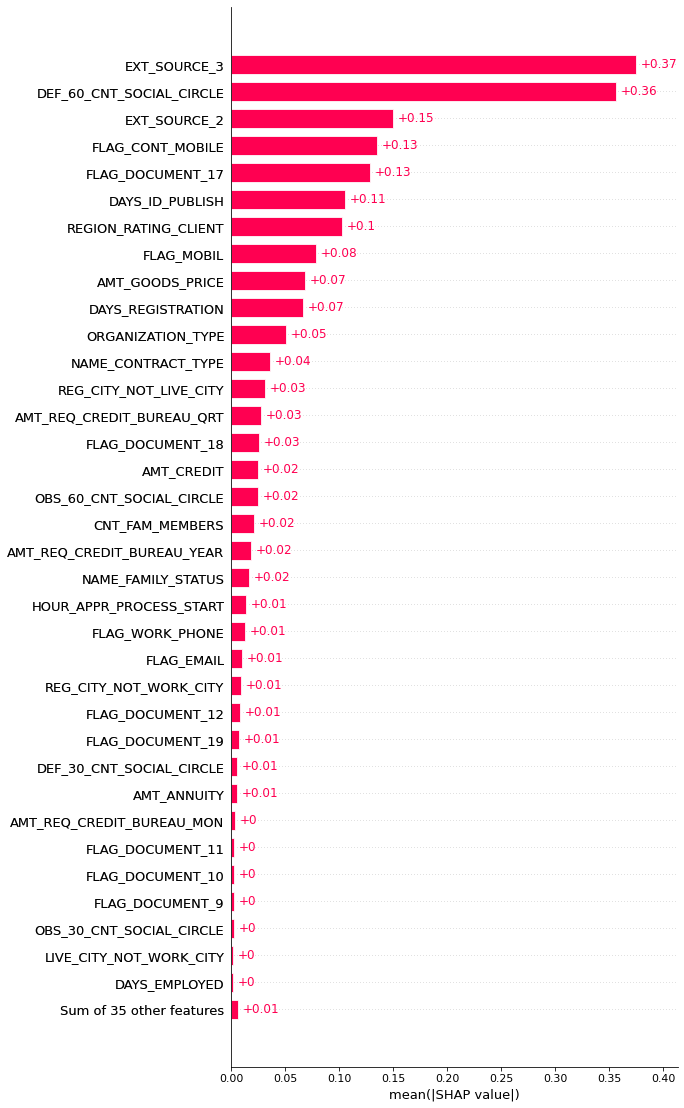

In [132]:
shap.plots.bar(shap_values, max_display=36)


Beeswarm :

ce graphique est conçu pour afficher un résumé dense en informations de la manière dont les principales caractéristiques d'un ensemble de données influencent la sortie du modèle.
Chaque instance de l'explication donnée est représentée par un seul point sur chaque graphique de caractéristiques. La position x du point est déterminée par la valeur SHAP (shap_values.value[instance,feature]) de cette caractéristique, et les points s'empilent le long de chaque ligne de caractéristique pour montrer la densité.
La couleur est utilisée pour afficher la valeur originale d'une caractéristique (shap_values.data[instance,feature]).

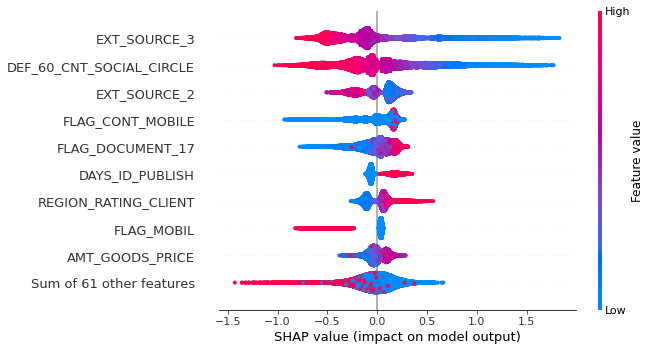

In [133]:
shap.plots.beeswarm(shap_values)


Dans le graphique ci-dessous, nous pouvons voir que la variable EXT_SOURCE_3 et DEF_60_CNT_SOCIAL_CIRCLE sont les caractéristiques les plus importantes en moyenne, et que les hautes valuers (en rouge) ont tendance avoir un impact négatif donc classe 1 défaillant alors que les basses valeurs ont tendance à avoir un impact postif donc classe 0 non-défaillant...

Le meilleur modèle est sélectionné et extrait. La suite concernera la préparation des données nécessaires au dashboard.

------------------------------------------------------------